In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import zscore
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv1D, GlobalAveragePooling1D, Multiply, Add, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

In [2]:
class_labels = pd.Series(["Walking", "Jogging", "walking_stairs_updown", "stumble_while_walking", "Fall_Recovery", "Fall_Initiation", "Impact", "Aftermath"])
n_classes = len(class_labels)
print("Number of Classes :", n_classes)

Number of Classes : 8


In [3]:
final_data = np.load("full_and_half_Final_data.npy")
print("Shape of Final Data :", final_data.shape)
final_data

Shape of Final Data : (11674, 200, 6)


array([[[ 3.70108067e-01,  1.84242152e+00, -2.09895659e+00,
          2.44204856e-01, -1.14811268e+00, -1.31094327e+00],
        [ 3.10724502e-01,  1.96257422e+00, -1.87010434e+00,
          7.64817407e-02, -1.28869163e+00, -1.17169055e+00],
        [-1.04960451e-01,  1.91451314e+00, -1.64125208e+00,
         -7.20730188e-02, -1.38753620e+00, -1.06573740e+00],
        ...,
        [-6.09720751e-01,  6.41615423e-02,  1.51182342e+00,
         -3.37363067e-02, -1.84222124e+00,  4.14579566e-01],
        [-7.28487880e-01,  4.01310021e-02,  1.56267948e+00,
          1.77115610e-01, -1.91910036e+00,  5.08423791e-01],
        [-8.17563227e-01, -1.04052239e-01,  1.86781582e+00,
          4.21512150e-01, -1.98938983e+00,  6.08322481e-01]],

       [[-7.14277170e-01,  2.00488654e-01,  1.69094994e+00,
          1.68401107e-01, -1.84585613e+00,  5.43452106e-01],
        [-7.71764267e-01,  2.00488654e-01,  1.75142020e+00,
          3.39260497e-01, -1.88641103e+00,  5.58390904e-01],
        [-7.52601

In [18]:
label = np.load("full_and_half_label.npy")
print("Shape of Label :", label.shape)
label

Shape of Label : (11674,)


array([0, 0, 0, ..., 5, 6, 7])

In [5]:
frequency = np.bincount(label)
frequency

array([1520, 1480, 1540,  279,  279, 3288, 1644, 1644])

([0, 1, 2, 3, 4, 5, 6, 7],
 [Text(0, 0, 'Walking'),
  Text(1, 0, 'Jogging'),
  Text(2, 0, 'walking_stairs_updown'),
  Text(3, 0, 'stumble_while_walking'),
  Text(4, 0, 'Fall_Recovery'),
  Text(5, 0, 'Fall_Initiation'),
  Text(6, 0, 'Impact'),
  Text(7, 0, 'Aftermath')])

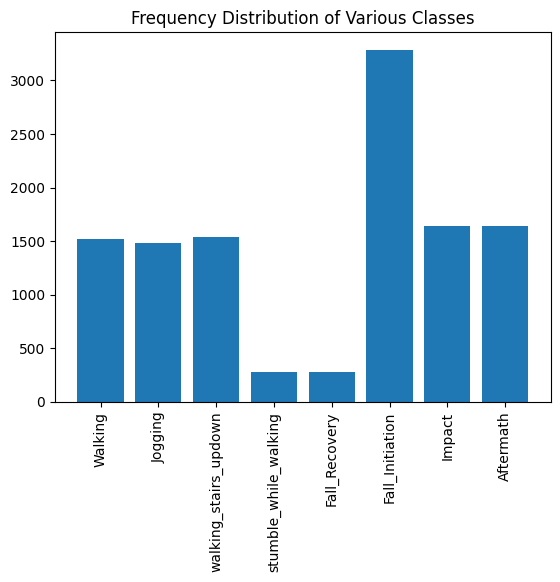

In [6]:
plt.bar(class_labels, frequency)
plt.title("Frequency Distribution of Various Classes")
plt.xticks(rotation=90)

In [19]:
label_copy = label
label = to_categorical(label, n_classes)
print("Shape of Label :", label.shape)
label

Shape of Label : (11674, 8)


array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

In [8]:
final_data = zscore(final_data, axis=1)
final_data

array([[[ 3.70108067e-01,  1.84242152e+00, -2.09895659e+00,
          2.44204856e-01, -1.14811268e+00, -1.31094327e+00],
        [ 3.10724502e-01,  1.96257422e+00, -1.87010434e+00,
          7.64817407e-02, -1.28869163e+00, -1.17169055e+00],
        [-1.04960451e-01,  1.91451314e+00, -1.64125208e+00,
         -7.20730188e-02, -1.38753620e+00, -1.06573740e+00],
        ...,
        [-6.09720751e-01,  6.41615423e-02,  1.51182342e+00,
         -3.37363067e-02, -1.84222124e+00,  4.14579566e-01],
        [-7.28487880e-01,  4.01310021e-02,  1.56267948e+00,
          1.77115610e-01, -1.91910036e+00,  5.08423791e-01],
        [-8.17563227e-01, -1.04052239e-01,  1.86781582e+00,
          4.21512150e-01, -1.98938983e+00,  6.08322481e-01]],

       [[-7.14277170e-01,  2.00488654e-01,  1.69094994e+00,
          1.68401107e-01, -1.84585613e+00,  5.43452106e-01],
        [-7.71764267e-01,  2.00488654e-01,  1.75142020e+00,
          3.39260497e-01, -1.88641103e+00,  5.58390904e-01],
        [-7.52601

In [9]:
I_Shape = final_data.shape[1:]
I_Shape

(200, 6)

In [24]:
def selective_kernel_conv(inputs, kernel_sizes, filters, use_bn=True, dropout_rate=0.2):
    conv_outputs = []
    for size in kernel_sizes:
        conv_output = Conv1D(filters=filters, kernel_size=size, padding='same', activation='relu', kernel_regularizer=l2(5e-4))(inputs)
        if use_bn:
            conv_output = BatchNormalization()(conv_output)
        conv_outputs.append(conv_output)

    combined_output = Add()(conv_outputs)
    excitation = GlobalAveragePooling1D()(combined_output)
    excitation = Dense(len(kernel_sizes), activation='relu')(excitation)
    excitation = Dense(filters, activation='sigmoid')(excitation)
    excitation = tf.expand_dims(excitation, axis=1)
    weighted_output = Multiply()([combined_output, excitation])

    if dropout_rate:
        weighted_output = Dropout(dropout_rate)(weighted_output)

    return weighted_output

def multi_head_self_attention(inputs, num_heads=8):
    attention_heads = []
    for _ in range(num_heads):
        attention_scores = Dense(inputs.shape[-1], activation='softmax')(inputs)
        attention_output = Multiply()([inputs, attention_scores])
        attention_heads.append(attention_output)
    return Add()(attention_heads)

def ENSEMBLE(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    x = selective_kernel_conv(inputs, kernel_sizes=[3, 5, 7, 9], filters=64, dropout_rate=0.2)
    x = multi_head_self_attention(x)

    x_shortcut = x

    x = selective_kernel_conv(x, kernel_sizes=[3, 5, 7, 9], filters=128, dropout_rate=0.2)
    x_shortcut = Conv1D(filters=128, kernel_size=1, padding='same')(x_shortcut)
    x = Add()([x, x_shortcut])
    x = multi_head_self_attention(x)

    x = selective_kernel_conv(x, kernel_sizes=[3, 5, 7, 9], filters=256, dropout_rate=0.2)
    x = multi_head_self_attention(x)

    x = GlobalAveragePooling1D()(x)

    x = Dense(256, activation='relu', kernel_regularizer=l2(5e-4))(x)
    x = Dropout(0.5)(x)

    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)

    return model

In [29]:
kf = StratifiedKFold(n_splits = 5, random_state = 42, shuffle = True)
fold_no = 1
accuracies = []
precisions = []
recalls = []
losses = []

Fold 1 :
Epoch 1/200
263/263 [==============================] - 49s 139ms/step - loss: 1.5768 - Accuracy: 0.5410 - precision: 0.7474 - recall: 0.3544 - val_loss: 2.7798 - val_Accuracy: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/200
263/263 [==============================] - 36s 136ms/step - loss: 0.8806 - Accuracy: 0.7693 - precision: 0.8359 - recall: 0.7051 - val_loss: 0.7774 - val_Accuracy: 0.7891 - val_precision: 0.8637 - val_recall: 0.7056
Epoch 3/200
263/263 [==============================] - 36s 135ms/step - loss: 0.7011 - Accuracy: 0.8259 - precision: 0.8716 - recall: 0.7776 - val_loss: 0.6831 - val_Accuracy: 0.8126 - val_precision: 0.8372 - val_recall: 0.7655
Epoch 4/200
263/263 [==============================] - 36s 135ms/step - loss: 0.6157 - Accuracy: 0.8510 - precision: 0.8875 - recall: 0.8125 - val_loss: 0.6302 - val_Accuracy: 0.8426 - val_precision: 0.8589 - val_recall: 0.8084
Epoch 5/200
263/263 [==============================] - 36s 135ms/st

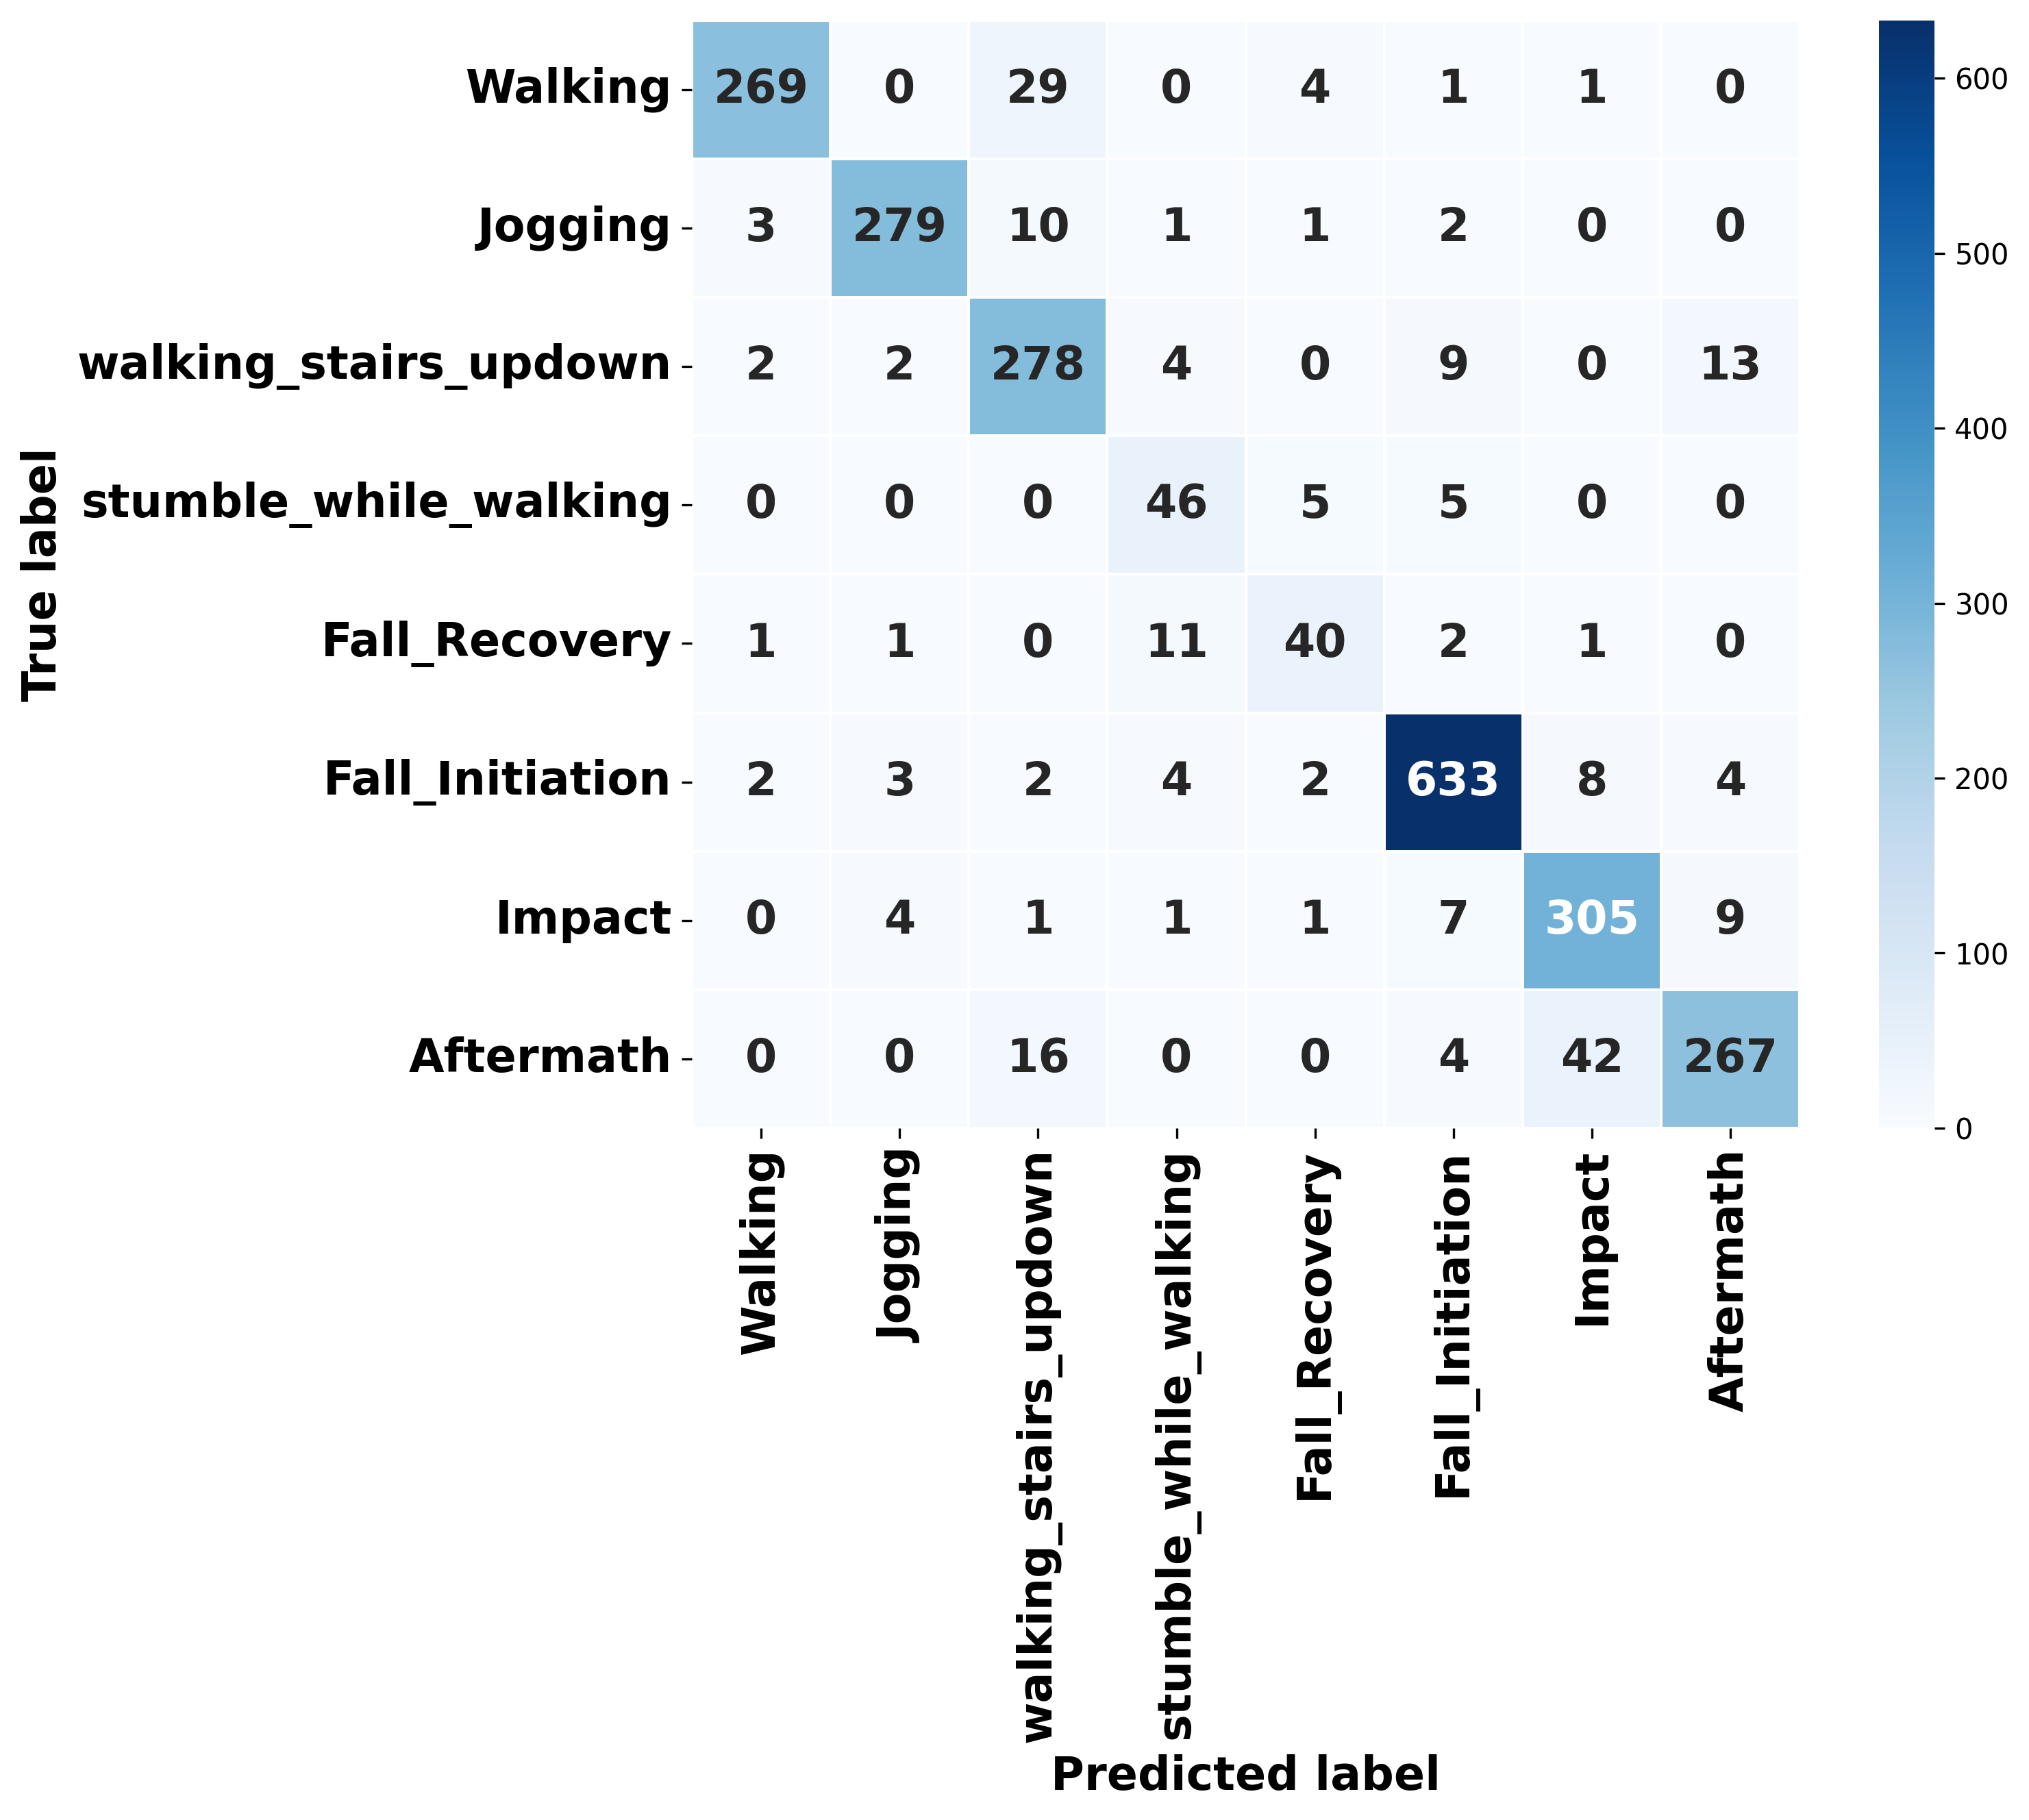

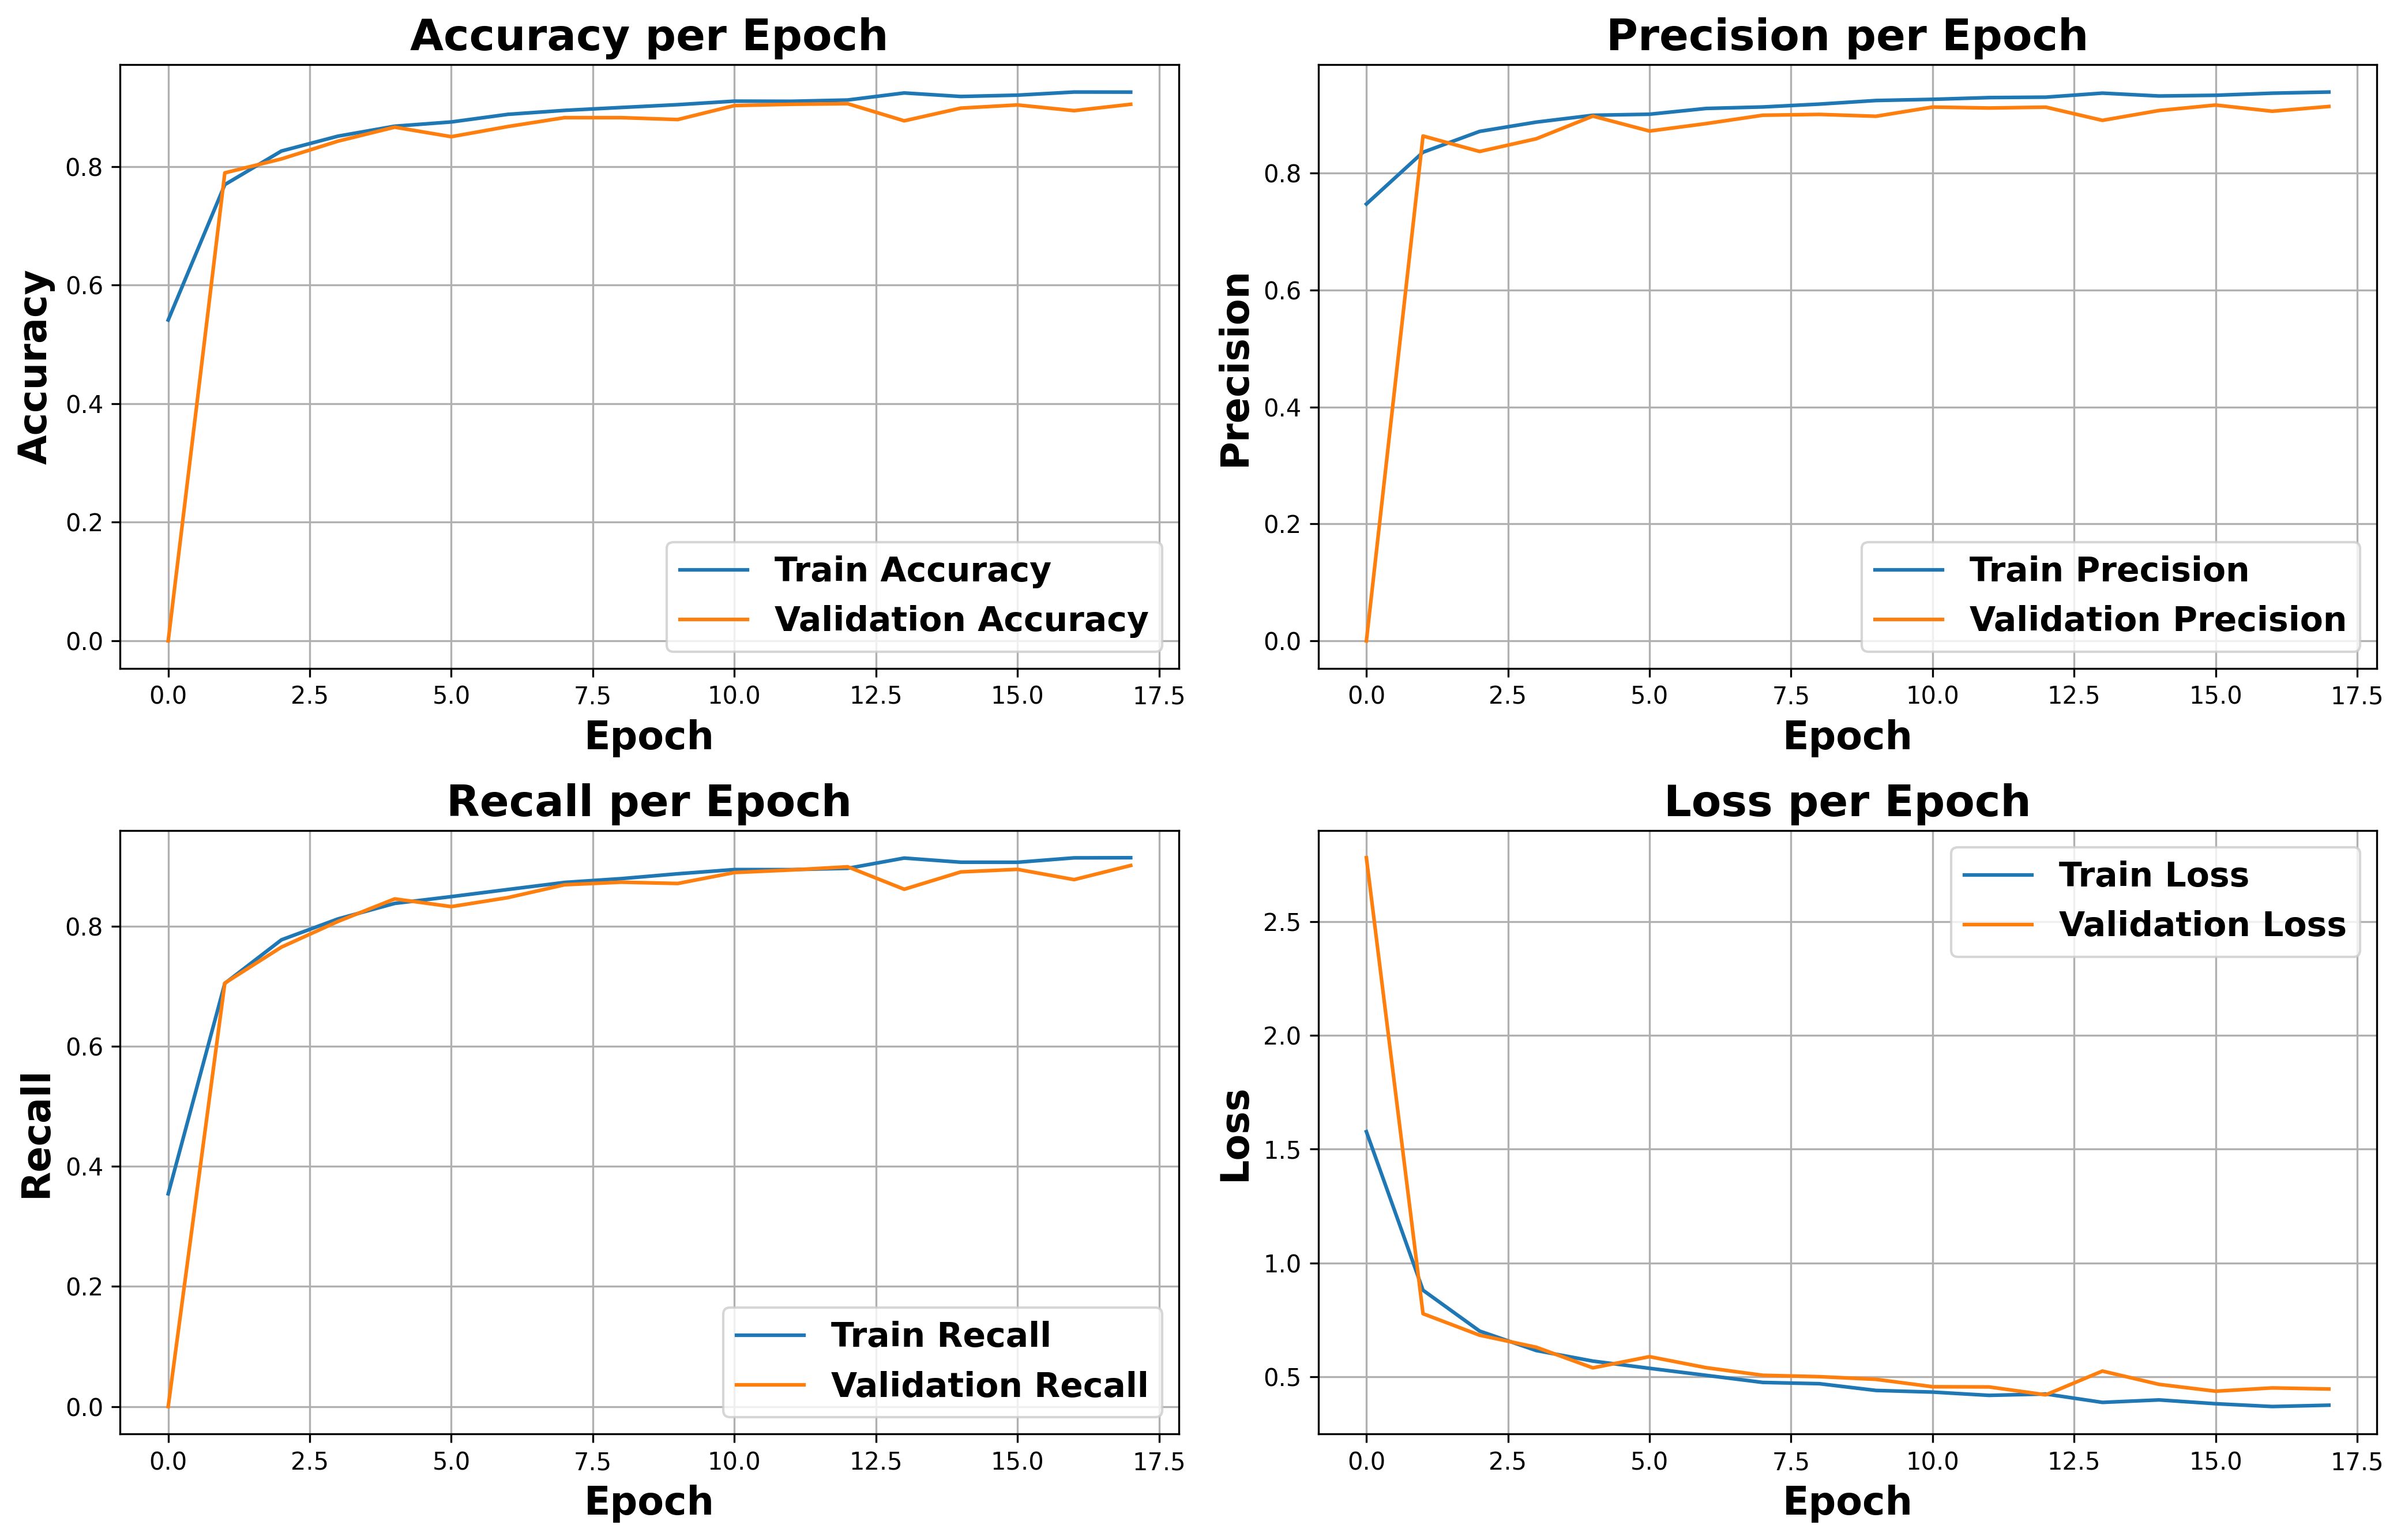

Fold 2 :
Epoch 1/200
263/263 [==============================] - 50s 140ms/step - loss: 1.6075 - Accuracy: 0.5264 - precision: 0.7344 - recall: 0.3319 - val_loss: 2.2148 - val_Accuracy: 0.2195 - val_precision: 0.3374 - val_recall: 0.0589
Epoch 2/200
263/263 [==============================] - 35s 134ms/step - loss: 0.9413 - Accuracy: 0.7453 - precision: 0.8194 - recall: 0.6616 - val_loss: 0.9996 - val_Accuracy: 0.6959 - val_precision: 0.7851 - val_recall: 0.6103
Epoch 3/200
263/263 [==============================] - 35s 134ms/step - loss: 0.7588 - Accuracy: 0.8017 - precision: 0.8529 - recall: 0.7500 - val_loss: 0.8031 - val_Accuracy: 0.7655 - val_precision: 0.8060 - val_recall: 0.7163
Epoch 4/200
263/263 [==============================] - 36s 135ms/step - loss: 0.6570 - Accuracy: 0.8359 - precision: 0.8755 - recall: 0.7979 - val_loss: 0.7060 - val_Accuracy: 0.7987 - val_precision: 0.8396 - val_recall: 0.7677
Epoch 5/200
263/263 [==============================] - 35s 134ms/step - loss: 0

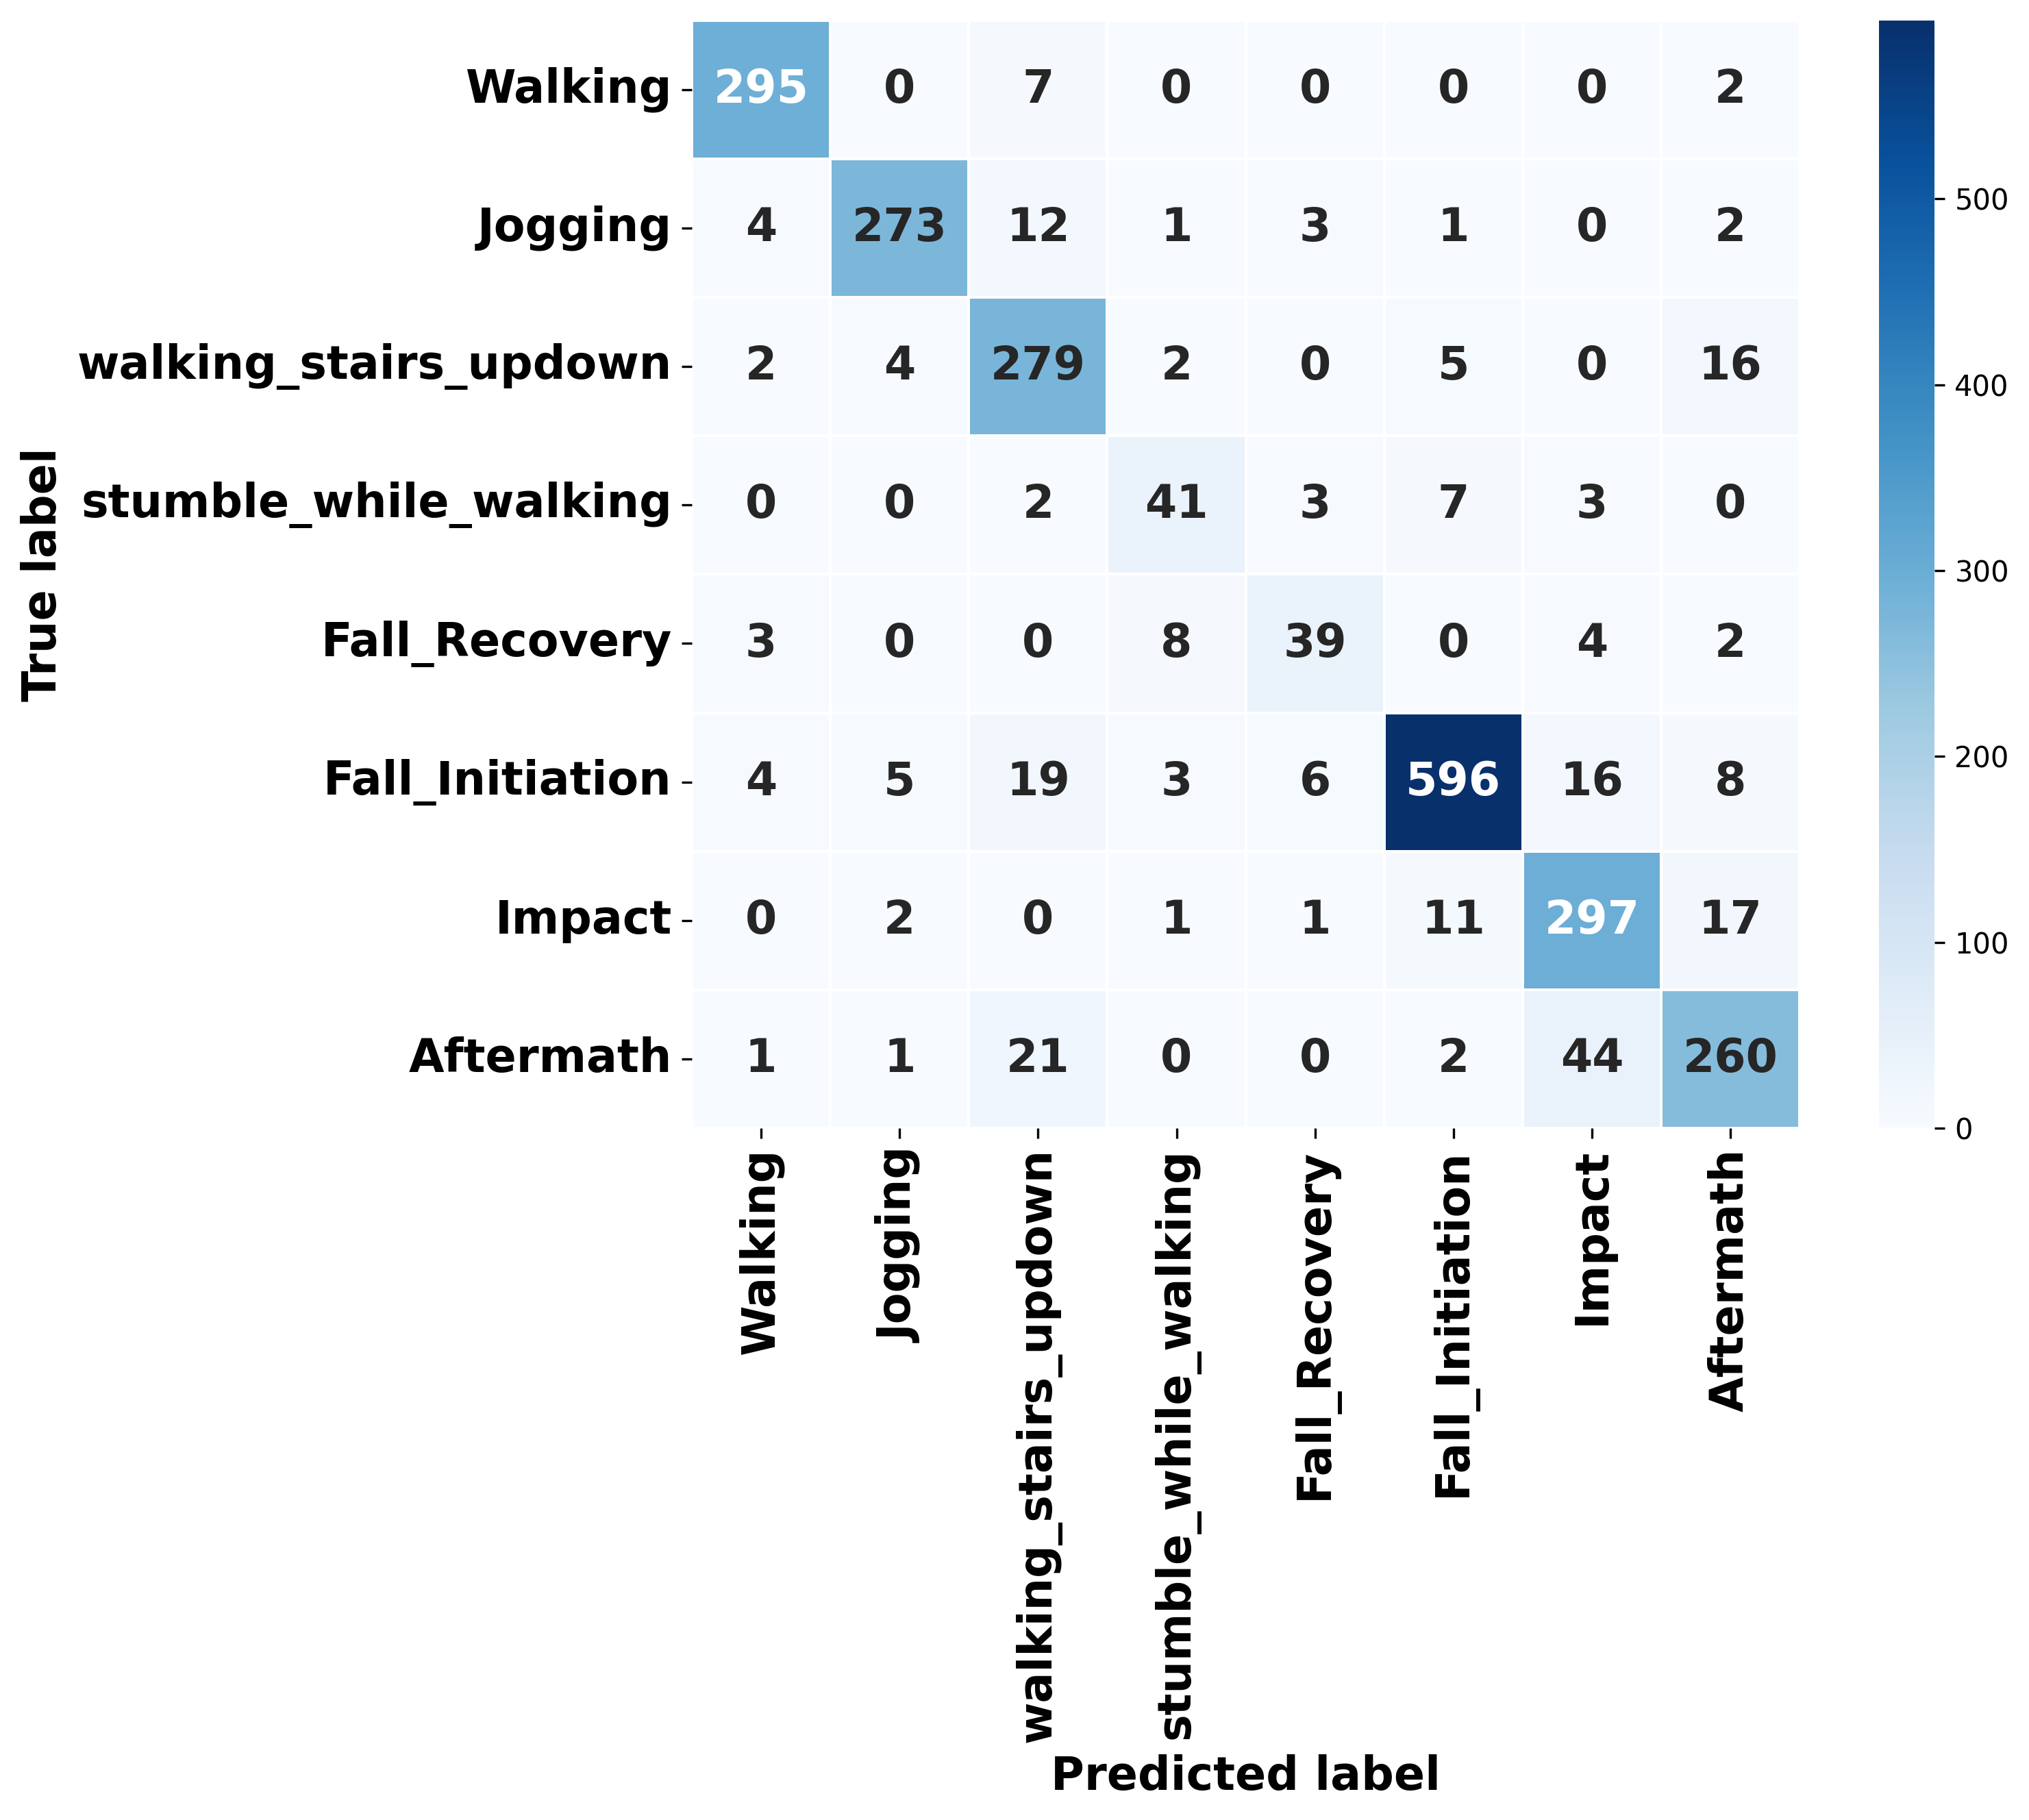

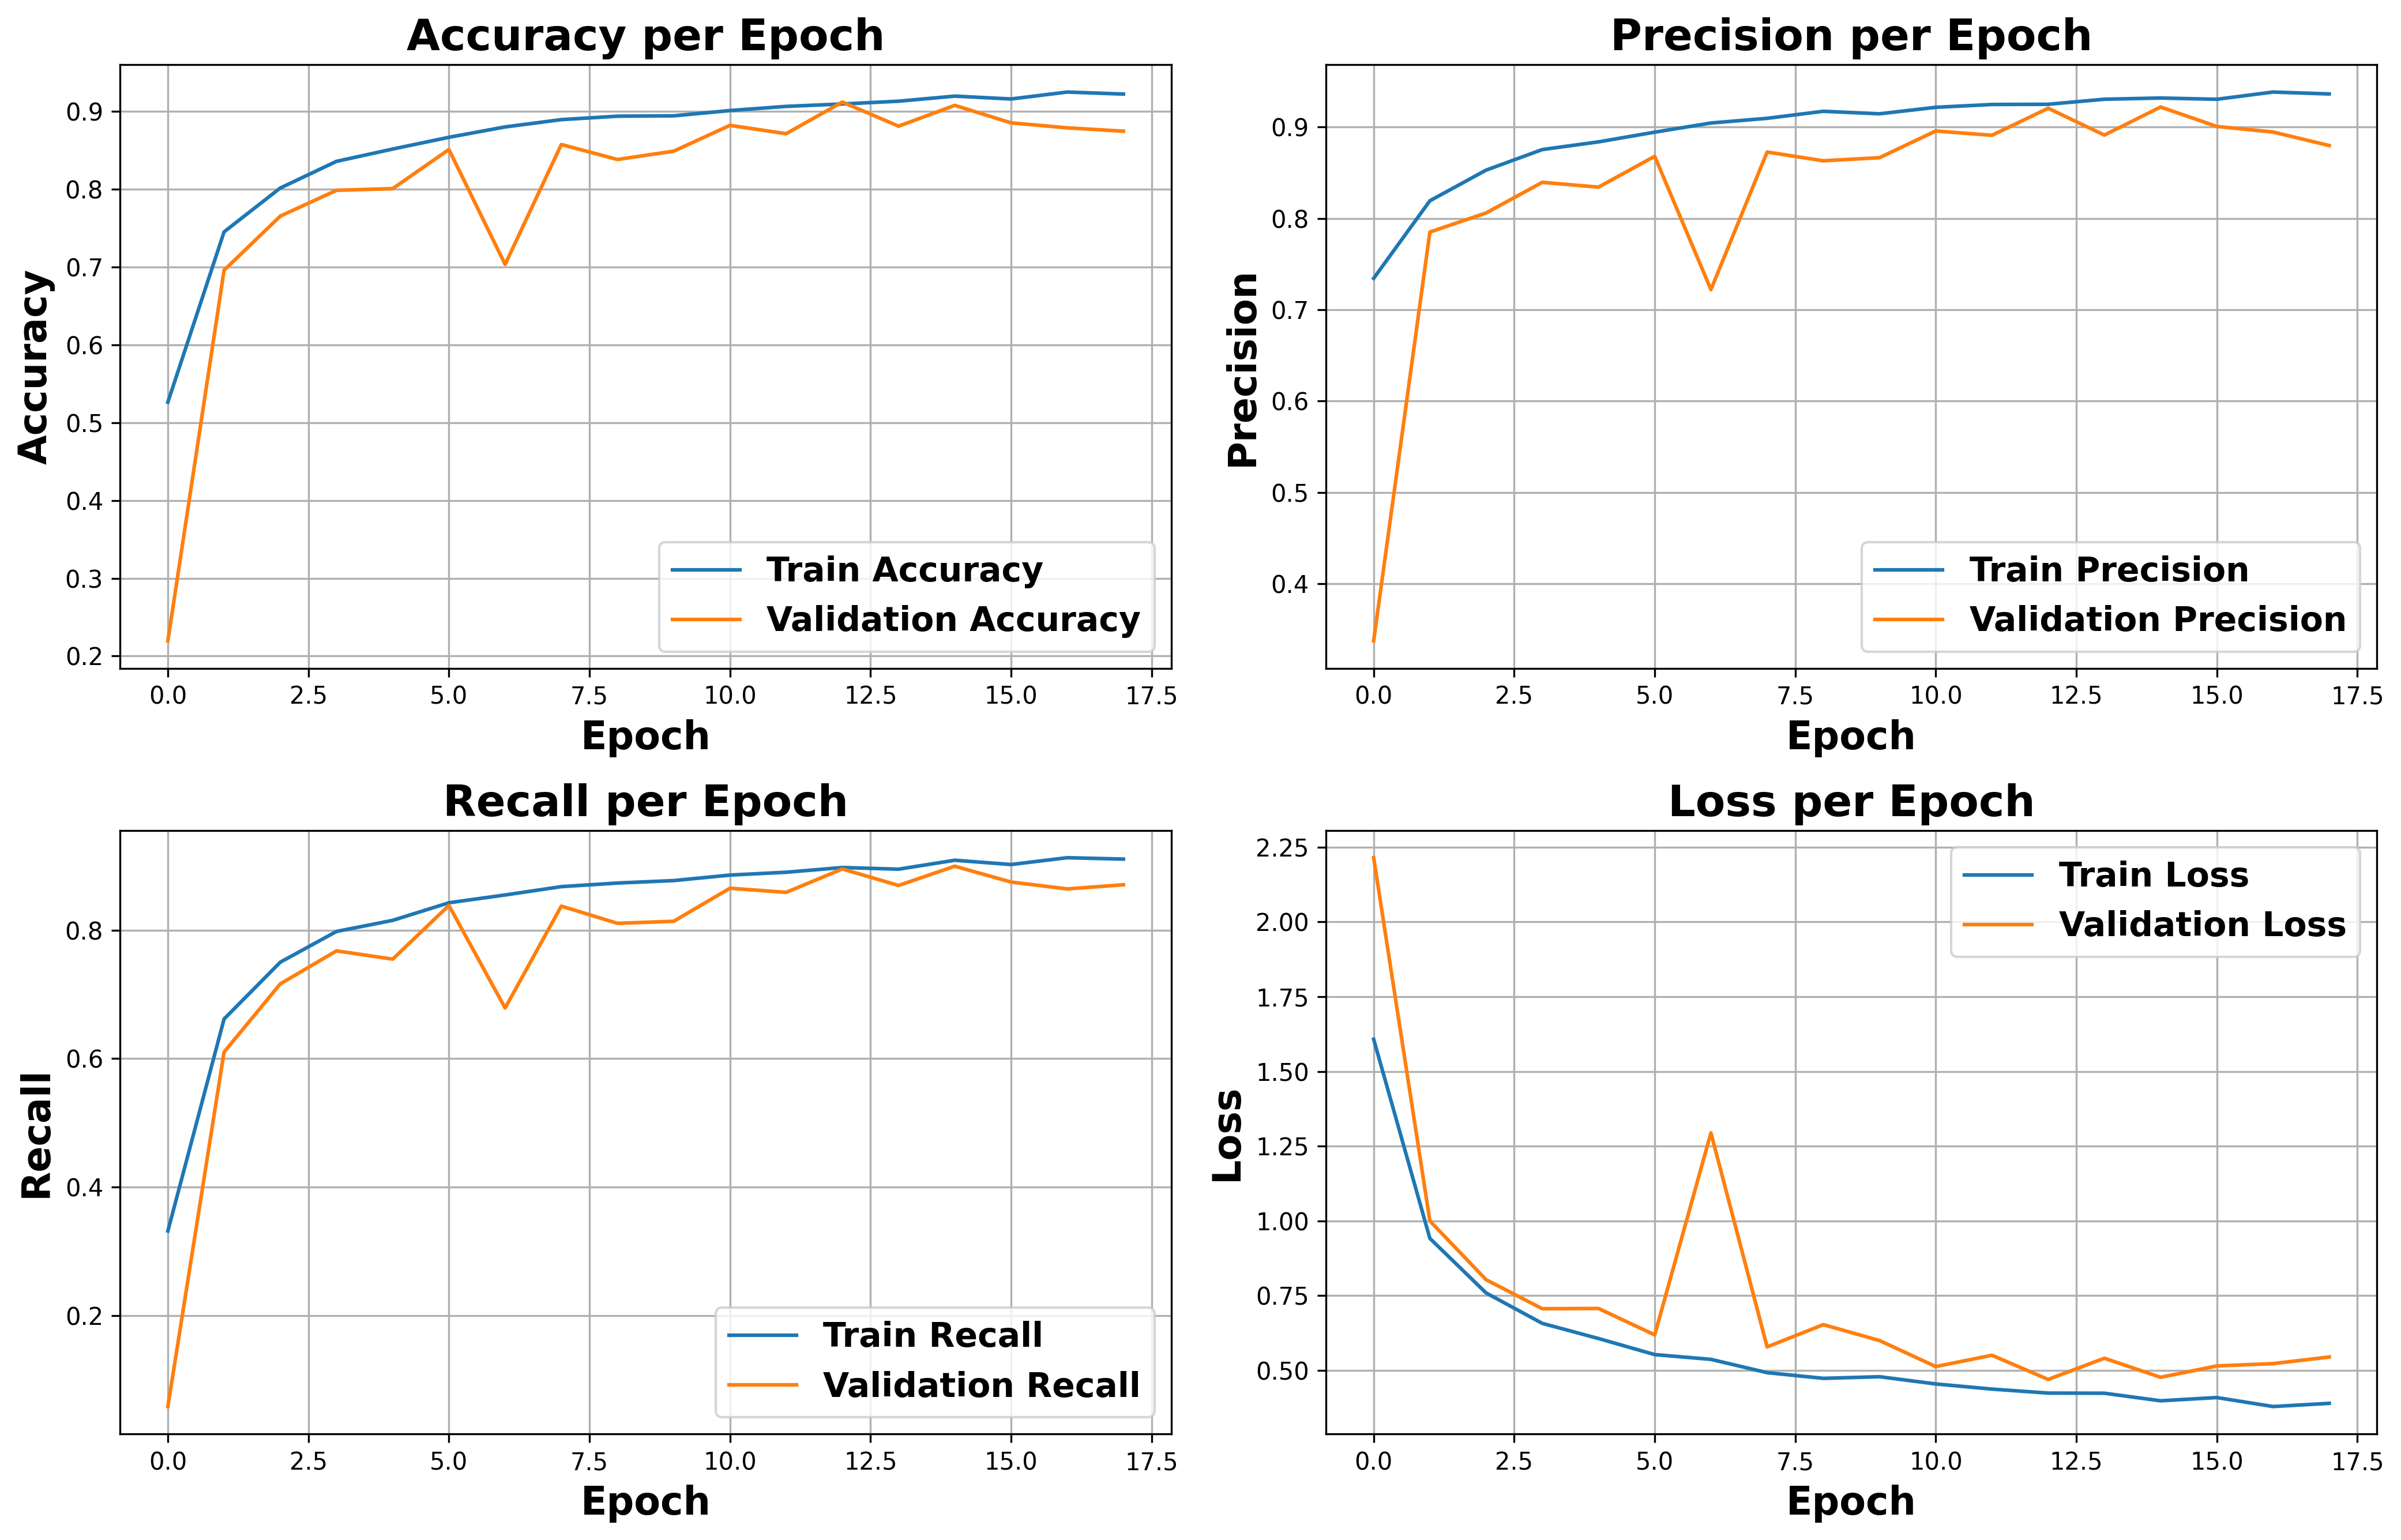

Fold 3 :
Epoch 1/200
263/263 [==============================] - 48s 140ms/step - loss: 1.5730 - Accuracy: 0.5349 - precision: 0.7518 - recall: 0.3449 - val_loss: 2.3742 - val_Accuracy: 0.1028 - val_precision: 0.1778 - val_recall: 0.0171
Epoch 2/200
263/263 [==============================] - 35s 134ms/step - loss: 0.9242 - Accuracy: 0.7448 - precision: 0.8286 - recall: 0.6659 - val_loss: 1.0003 - val_Accuracy: 0.7066 - val_precision: 0.7715 - val_recall: 0.6039
Epoch 3/200
263/263 [==============================] - 35s 135ms/step - loss: 0.7242 - Accuracy: 0.8174 - precision: 0.8637 - recall: 0.7653 - val_loss: 0.9346 - val_Accuracy: 0.7495 - val_precision: 0.8025 - val_recall: 0.7002
Epoch 4/200
263/263 [==============================] - 35s 134ms/step - loss: 0.6431 - Accuracy: 0.8426 - precision: 0.8781 - recall: 0.8070 - val_loss: 0.6218 - val_Accuracy: 0.8490 - val_precision: 0.8804 - val_recall: 0.8116
Epoch 5/200
263/263 [==============================] - 35s 134ms/step - loss: 0

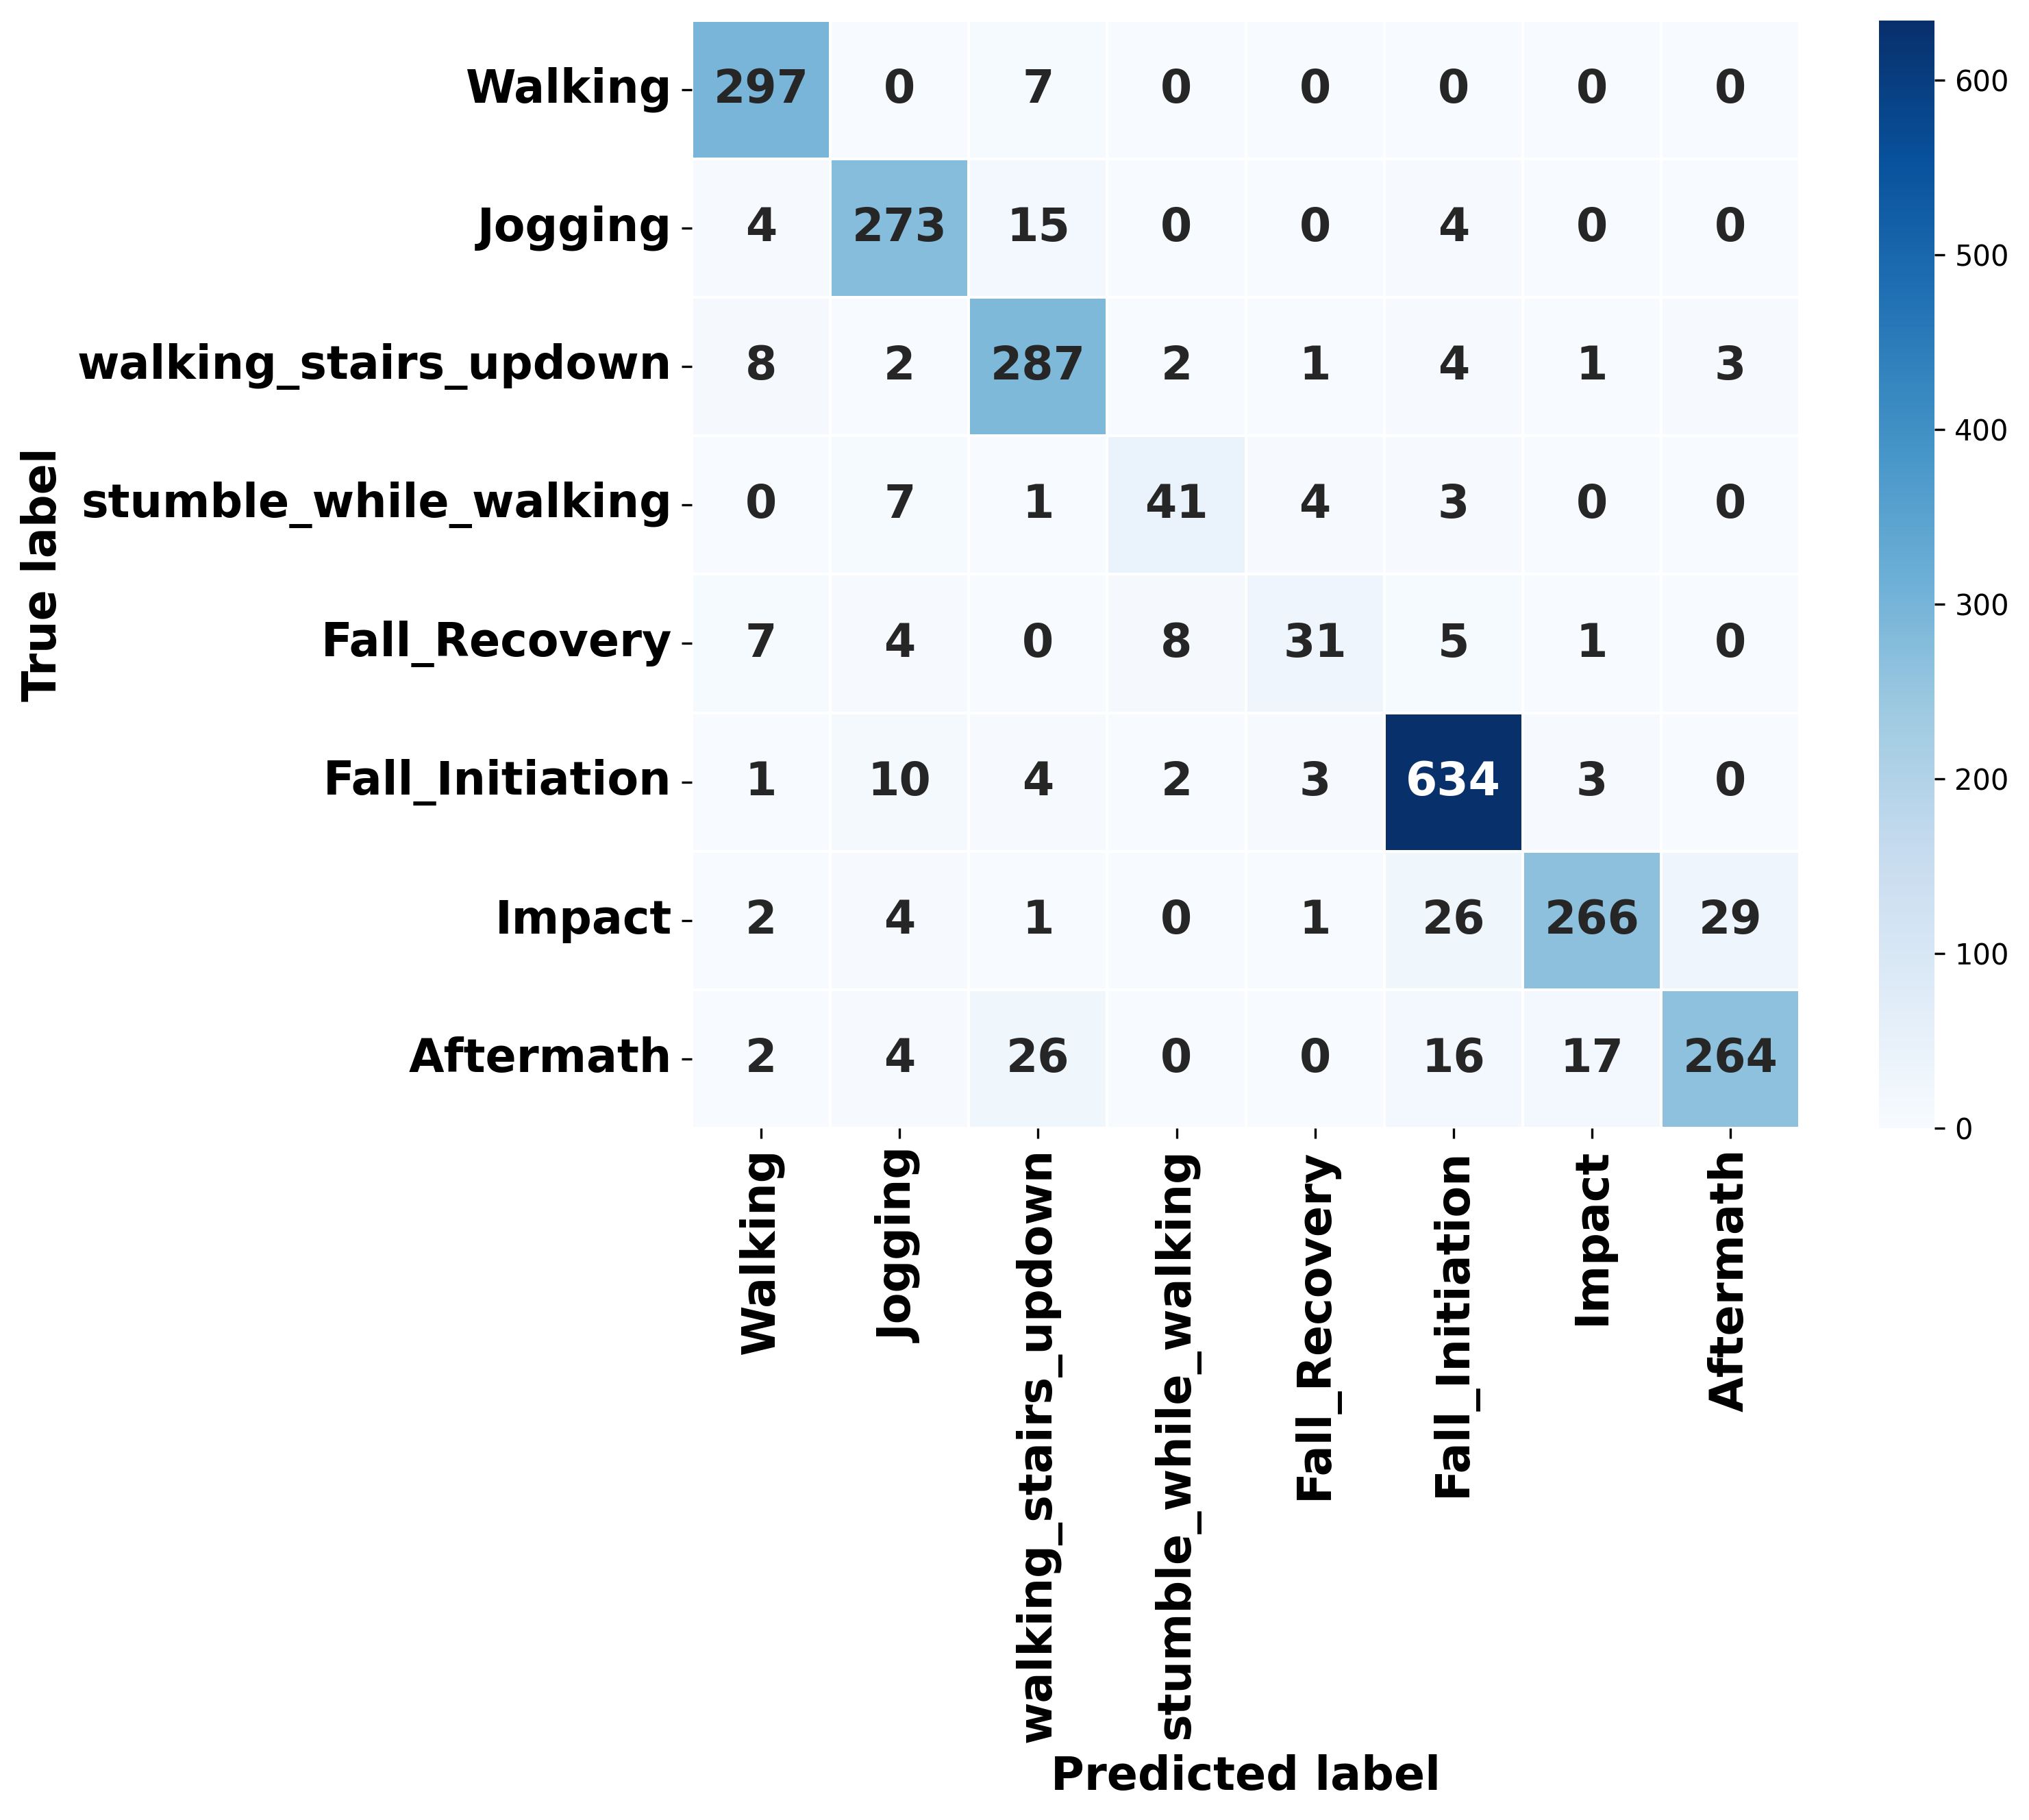

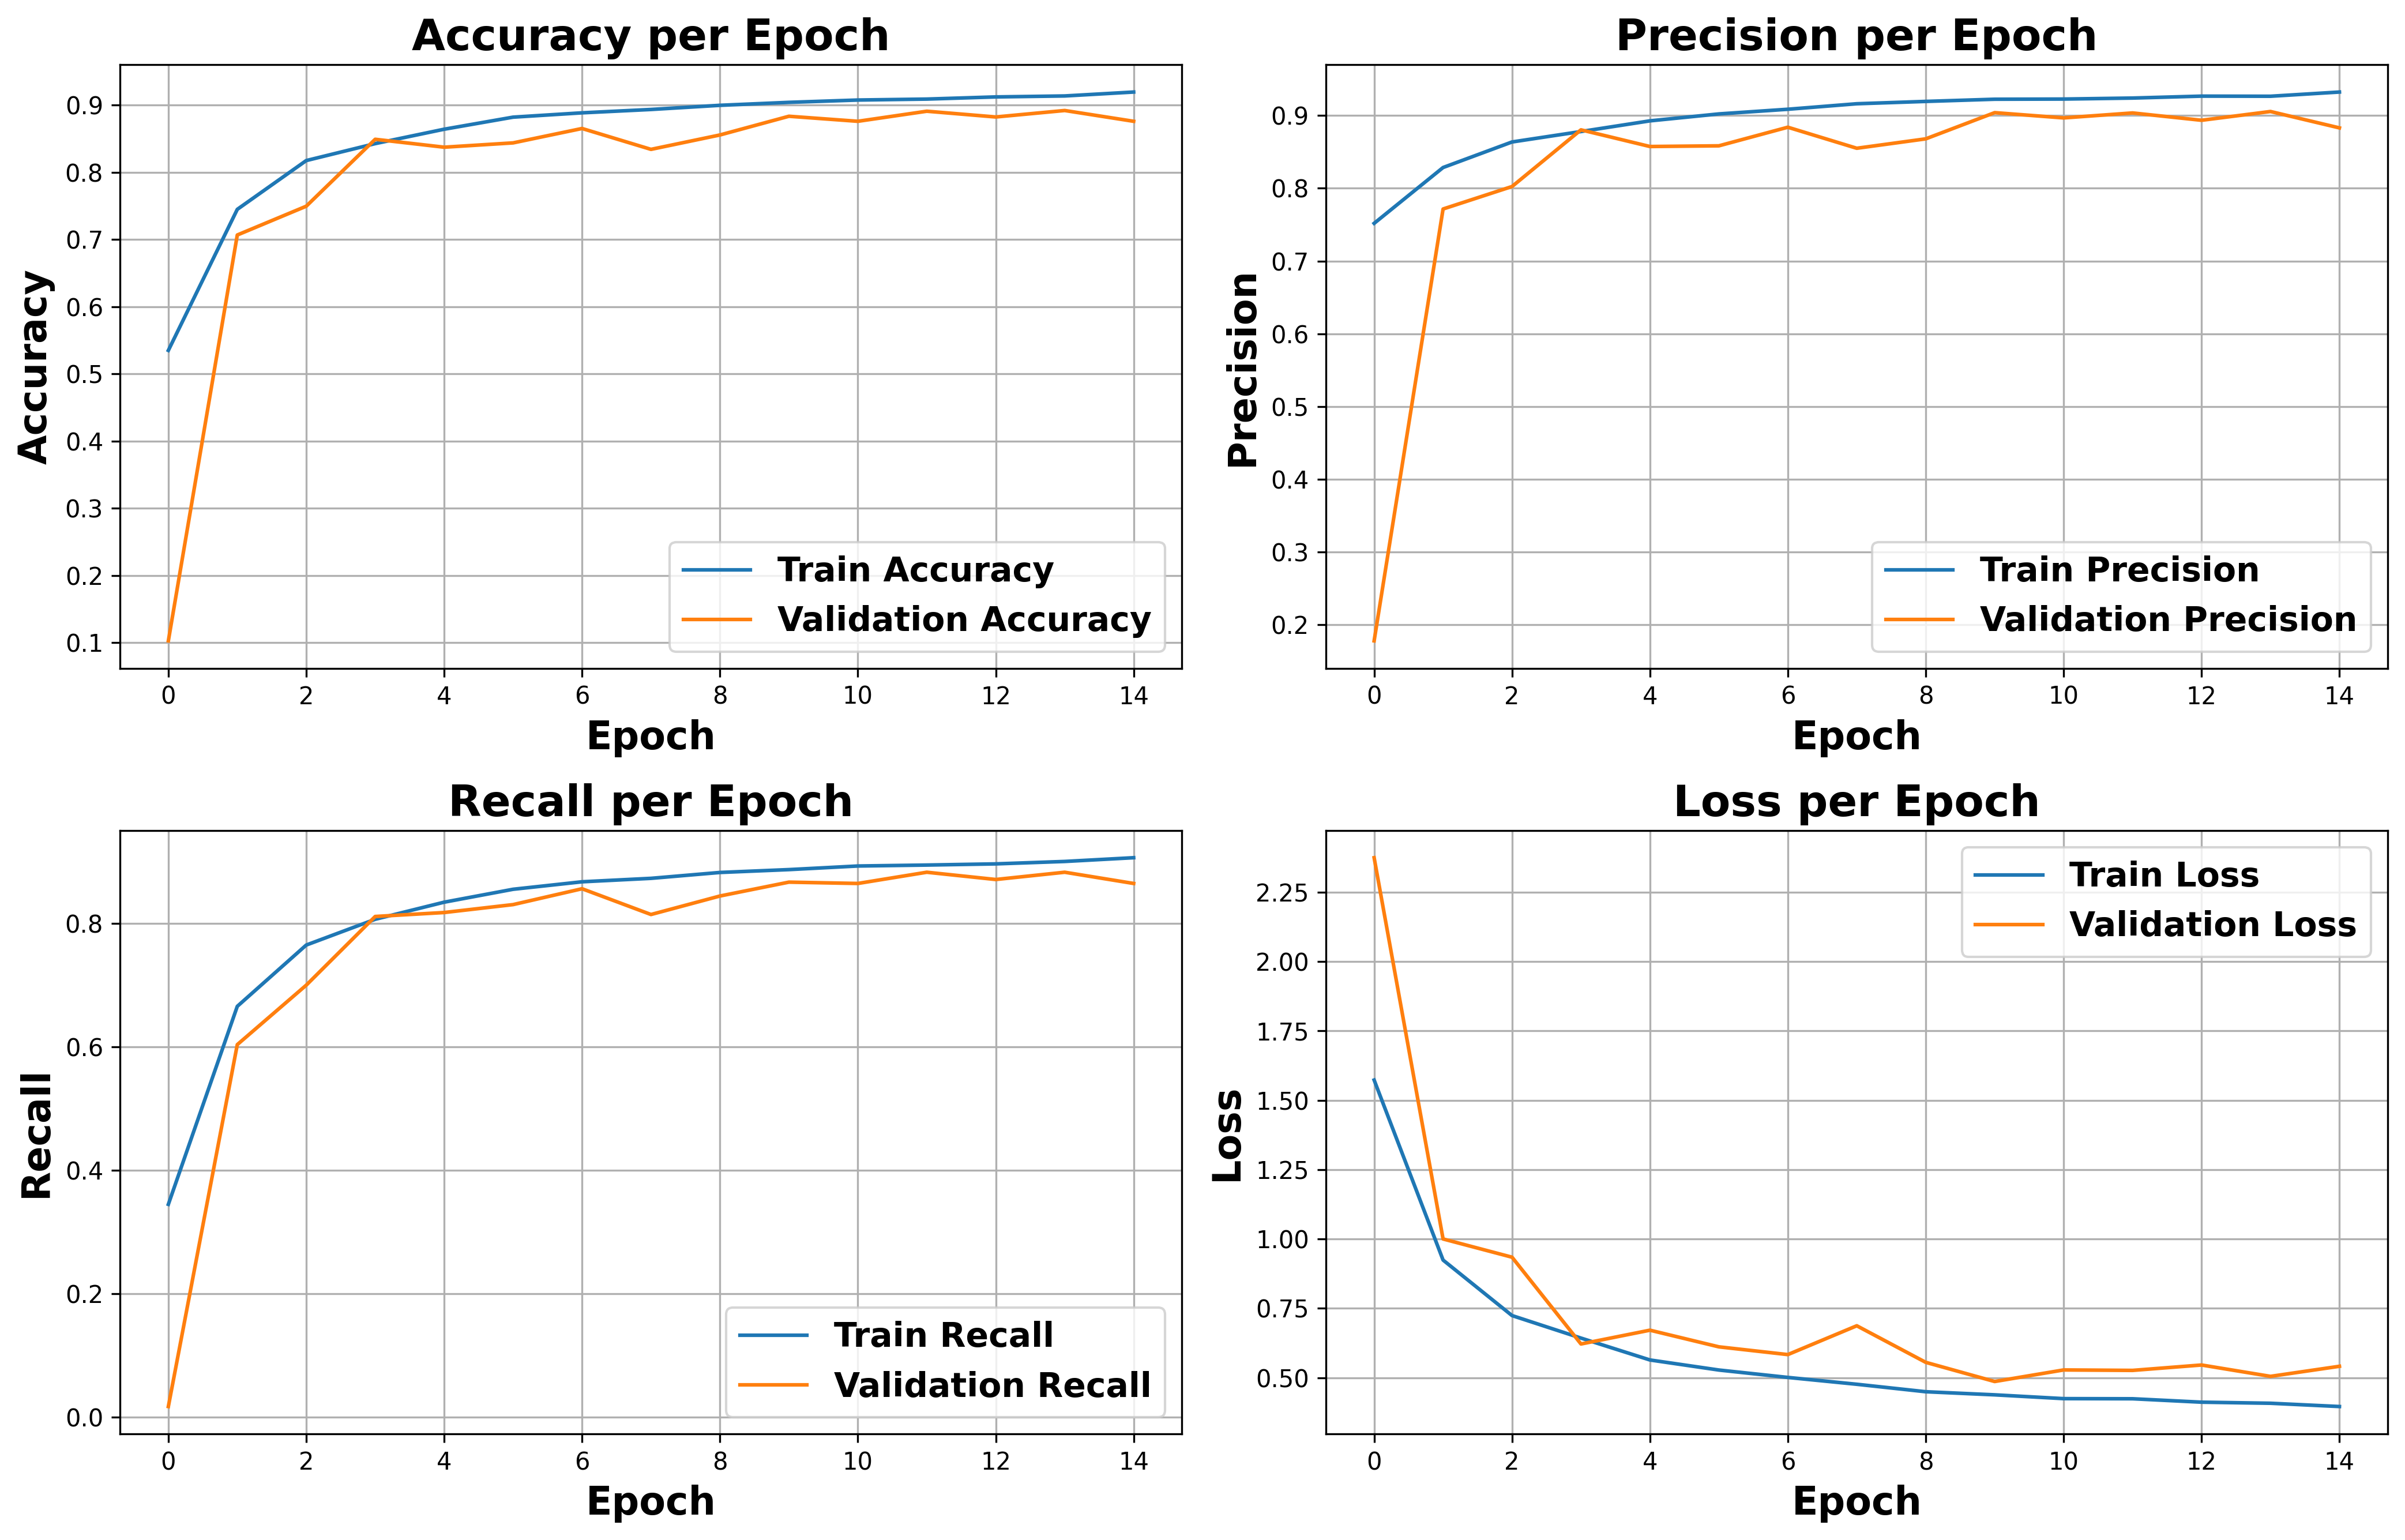

Fold 4 :
Epoch 1/200
263/263 [==============================] - 48s 139ms/step - loss: 1.5704 - Accuracy: 0.5291 - precision: 0.7543 - recall: 0.3349 - val_loss: 2.1346 - val_Accuracy: 0.1981 - val_precision: 0.3507 - val_recall: 0.1081
Epoch 2/200
263/263 [==============================] - 35s 134ms/step - loss: 0.8769 - Accuracy: 0.7687 - precision: 0.8338 - recall: 0.6948 - val_loss: 0.7975 - val_Accuracy: 0.7848 - val_precision: 0.8412 - val_recall: 0.7259
Epoch 3/200
263/263 [==============================] - 35s 134ms/step - loss: 0.7239 - Accuracy: 0.8175 - precision: 0.8635 - recall: 0.7648 - val_loss: 0.6666 - val_Accuracy: 0.8287 - val_precision: 0.8606 - val_recall: 0.8062
Epoch 4/200
263/263 [==============================] - 35s 134ms/step - loss: 0.6282 - Accuracy: 0.8512 - precision: 0.8878 - recall: 0.8107 - val_loss: 0.6482 - val_Accuracy: 0.8212 - val_precision: 0.8630 - val_recall: 0.7891
Epoch 5/200
263/263 [==============================] - 36s 135ms/step - loss: 0

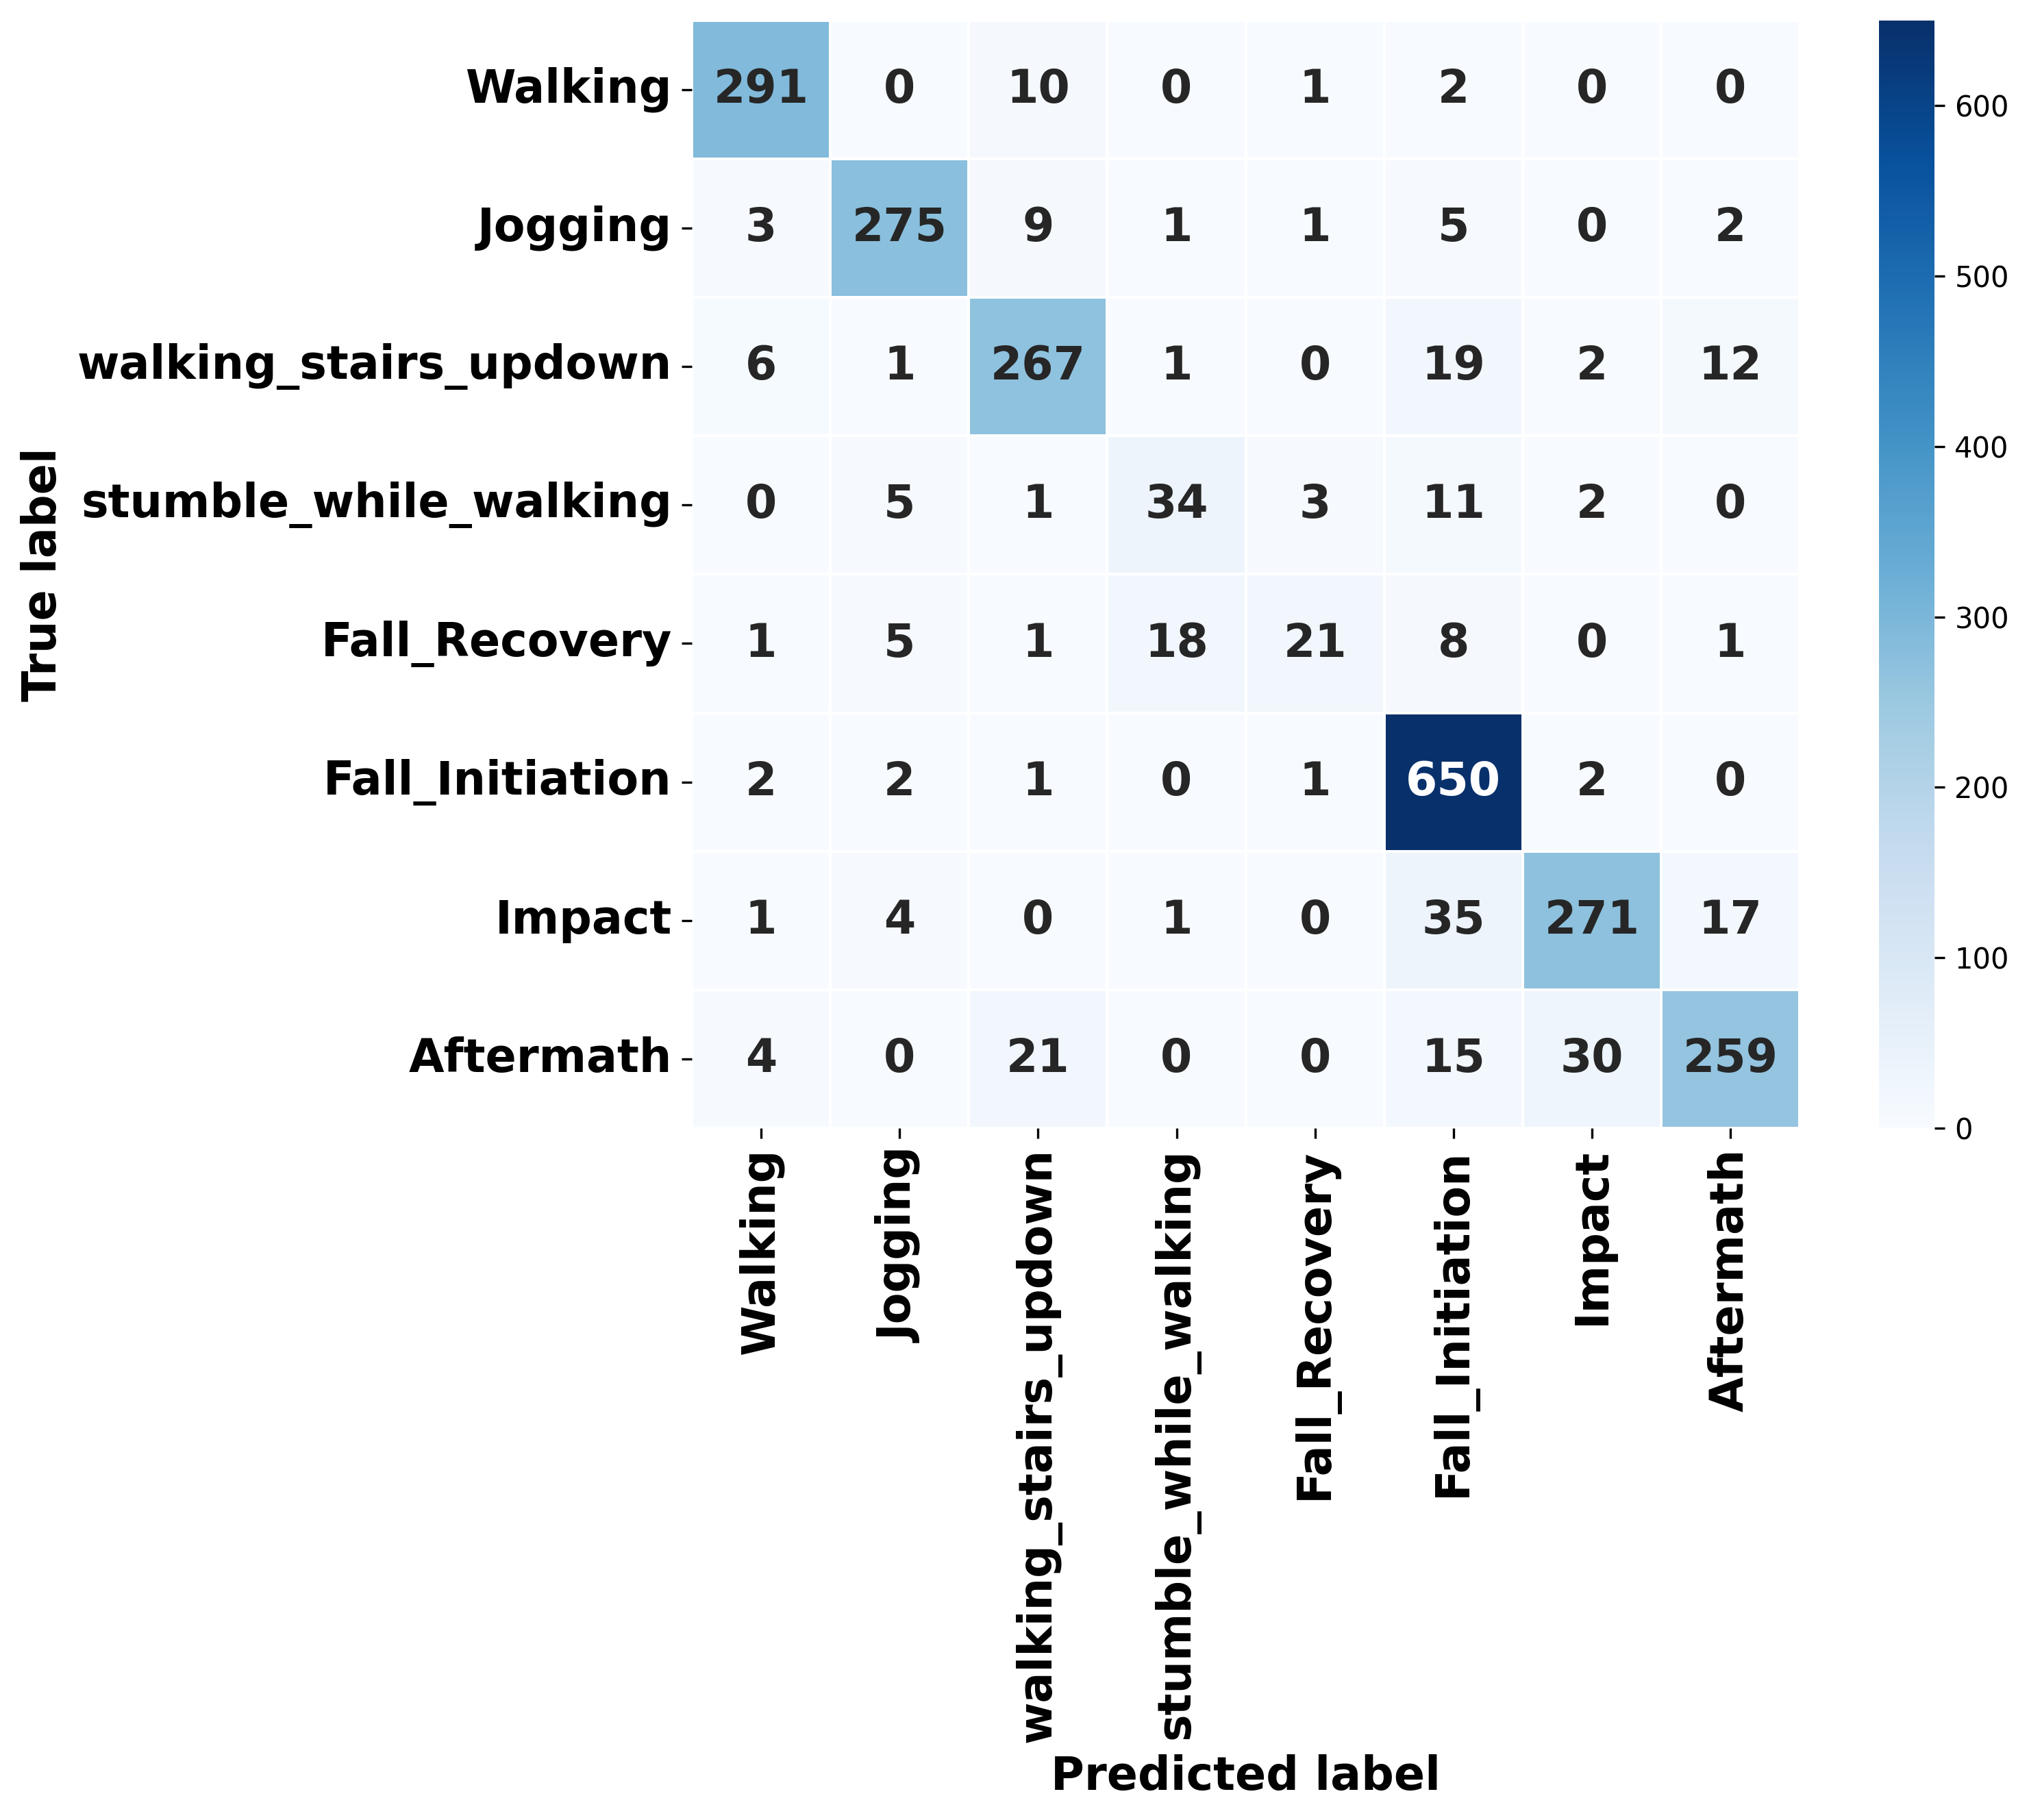

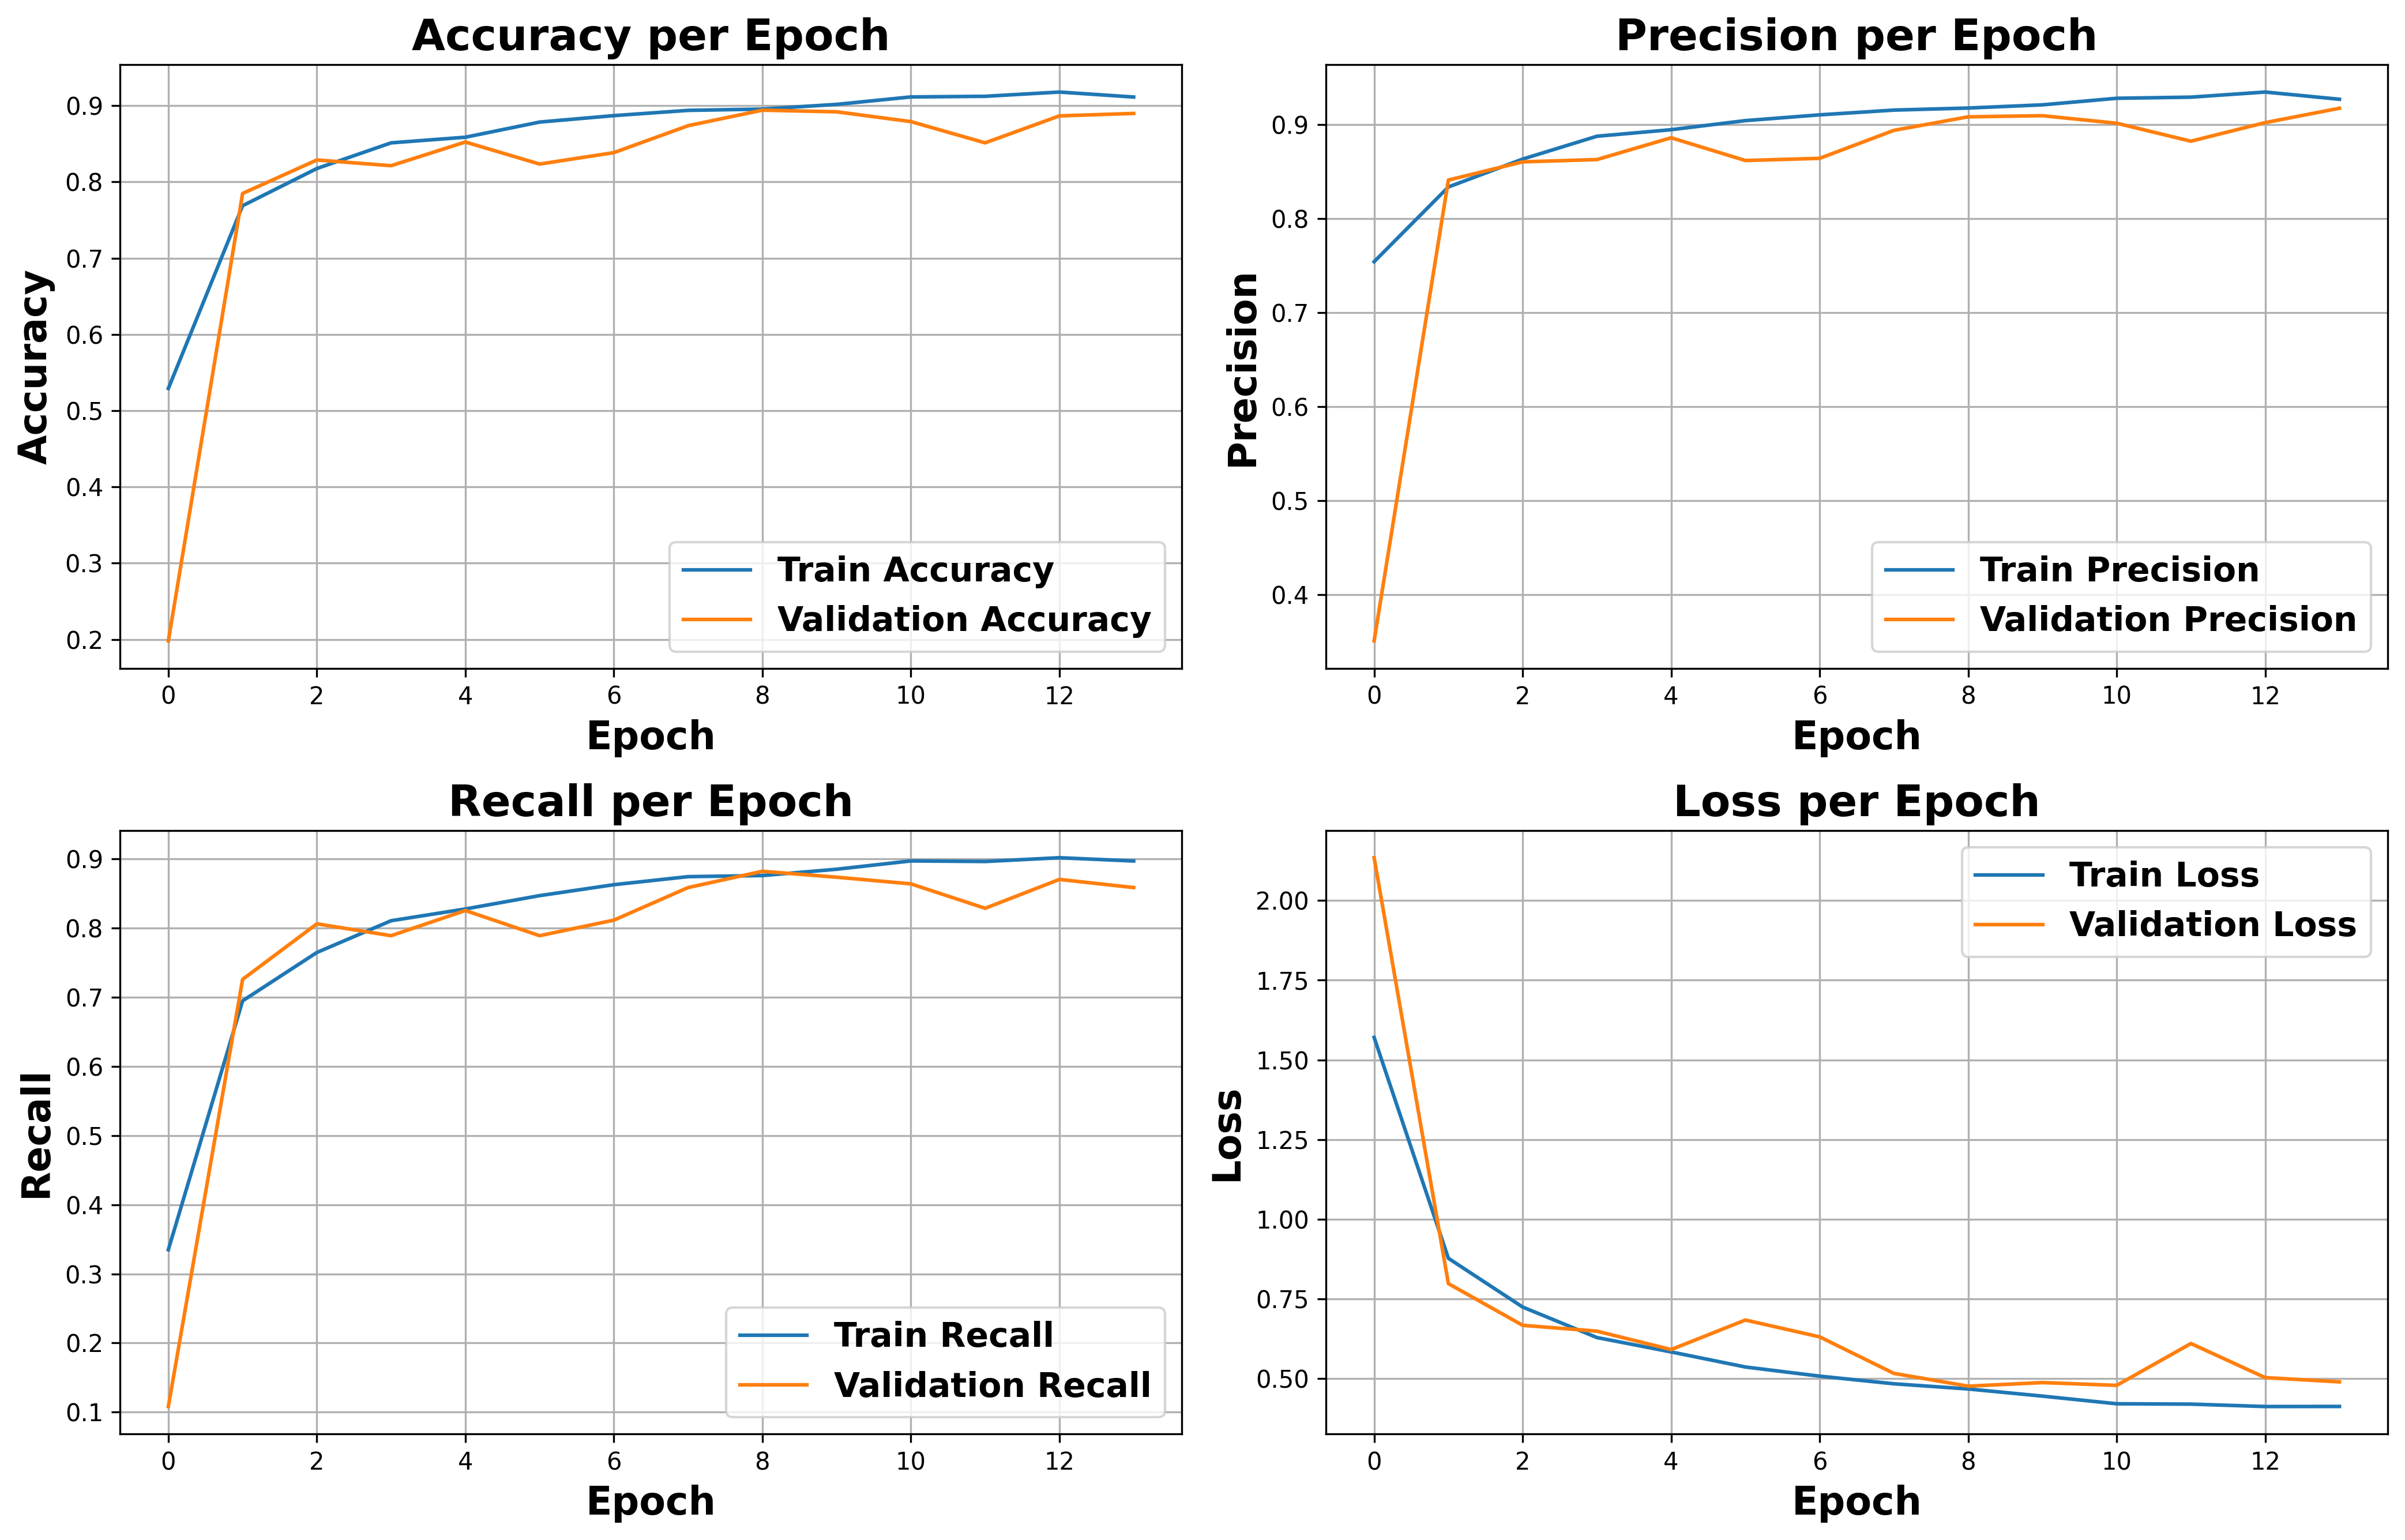

Fold 5 :
Epoch 1/200
263/263 [==============================] - 50s 140ms/step - loss: 1.6056 - Accuracy: 0.5193 - precision: 0.7364 - recall: 0.3291 - val_loss: 2.3003 - val_Accuracy: 0.1702 - val_precision: 0.2143 - val_recall: 0.0996
Epoch 2/200
263/263 [==============================] - 35s 134ms/step - loss: 0.9277 - Accuracy: 0.7573 - precision: 0.8268 - recall: 0.6803 - val_loss: 1.0452 - val_Accuracy: 0.6970 - val_precision: 0.7466 - val_recall: 0.5964
Epoch 3/200
263/263 [==============================] - 35s 134ms/step - loss: 0.7704 - Accuracy: 0.7988 - precision: 0.8551 - recall: 0.7472 - val_loss: 0.7761 - val_Accuracy: 0.7762 - val_precision: 0.8368 - val_recall: 0.7355
Epoch 4/200
263/263 [==============================] - 35s 134ms/step - loss: 0.6717 - Accuracy: 0.8330 - precision: 0.8763 - recall: 0.7942 - val_loss: 0.7671 - val_Accuracy: 0.7934 - val_precision: 0.8345 - val_recall: 0.7559
Epoch 5/200
263/263 [==============================] - 35s 134ms/step - loss: 0

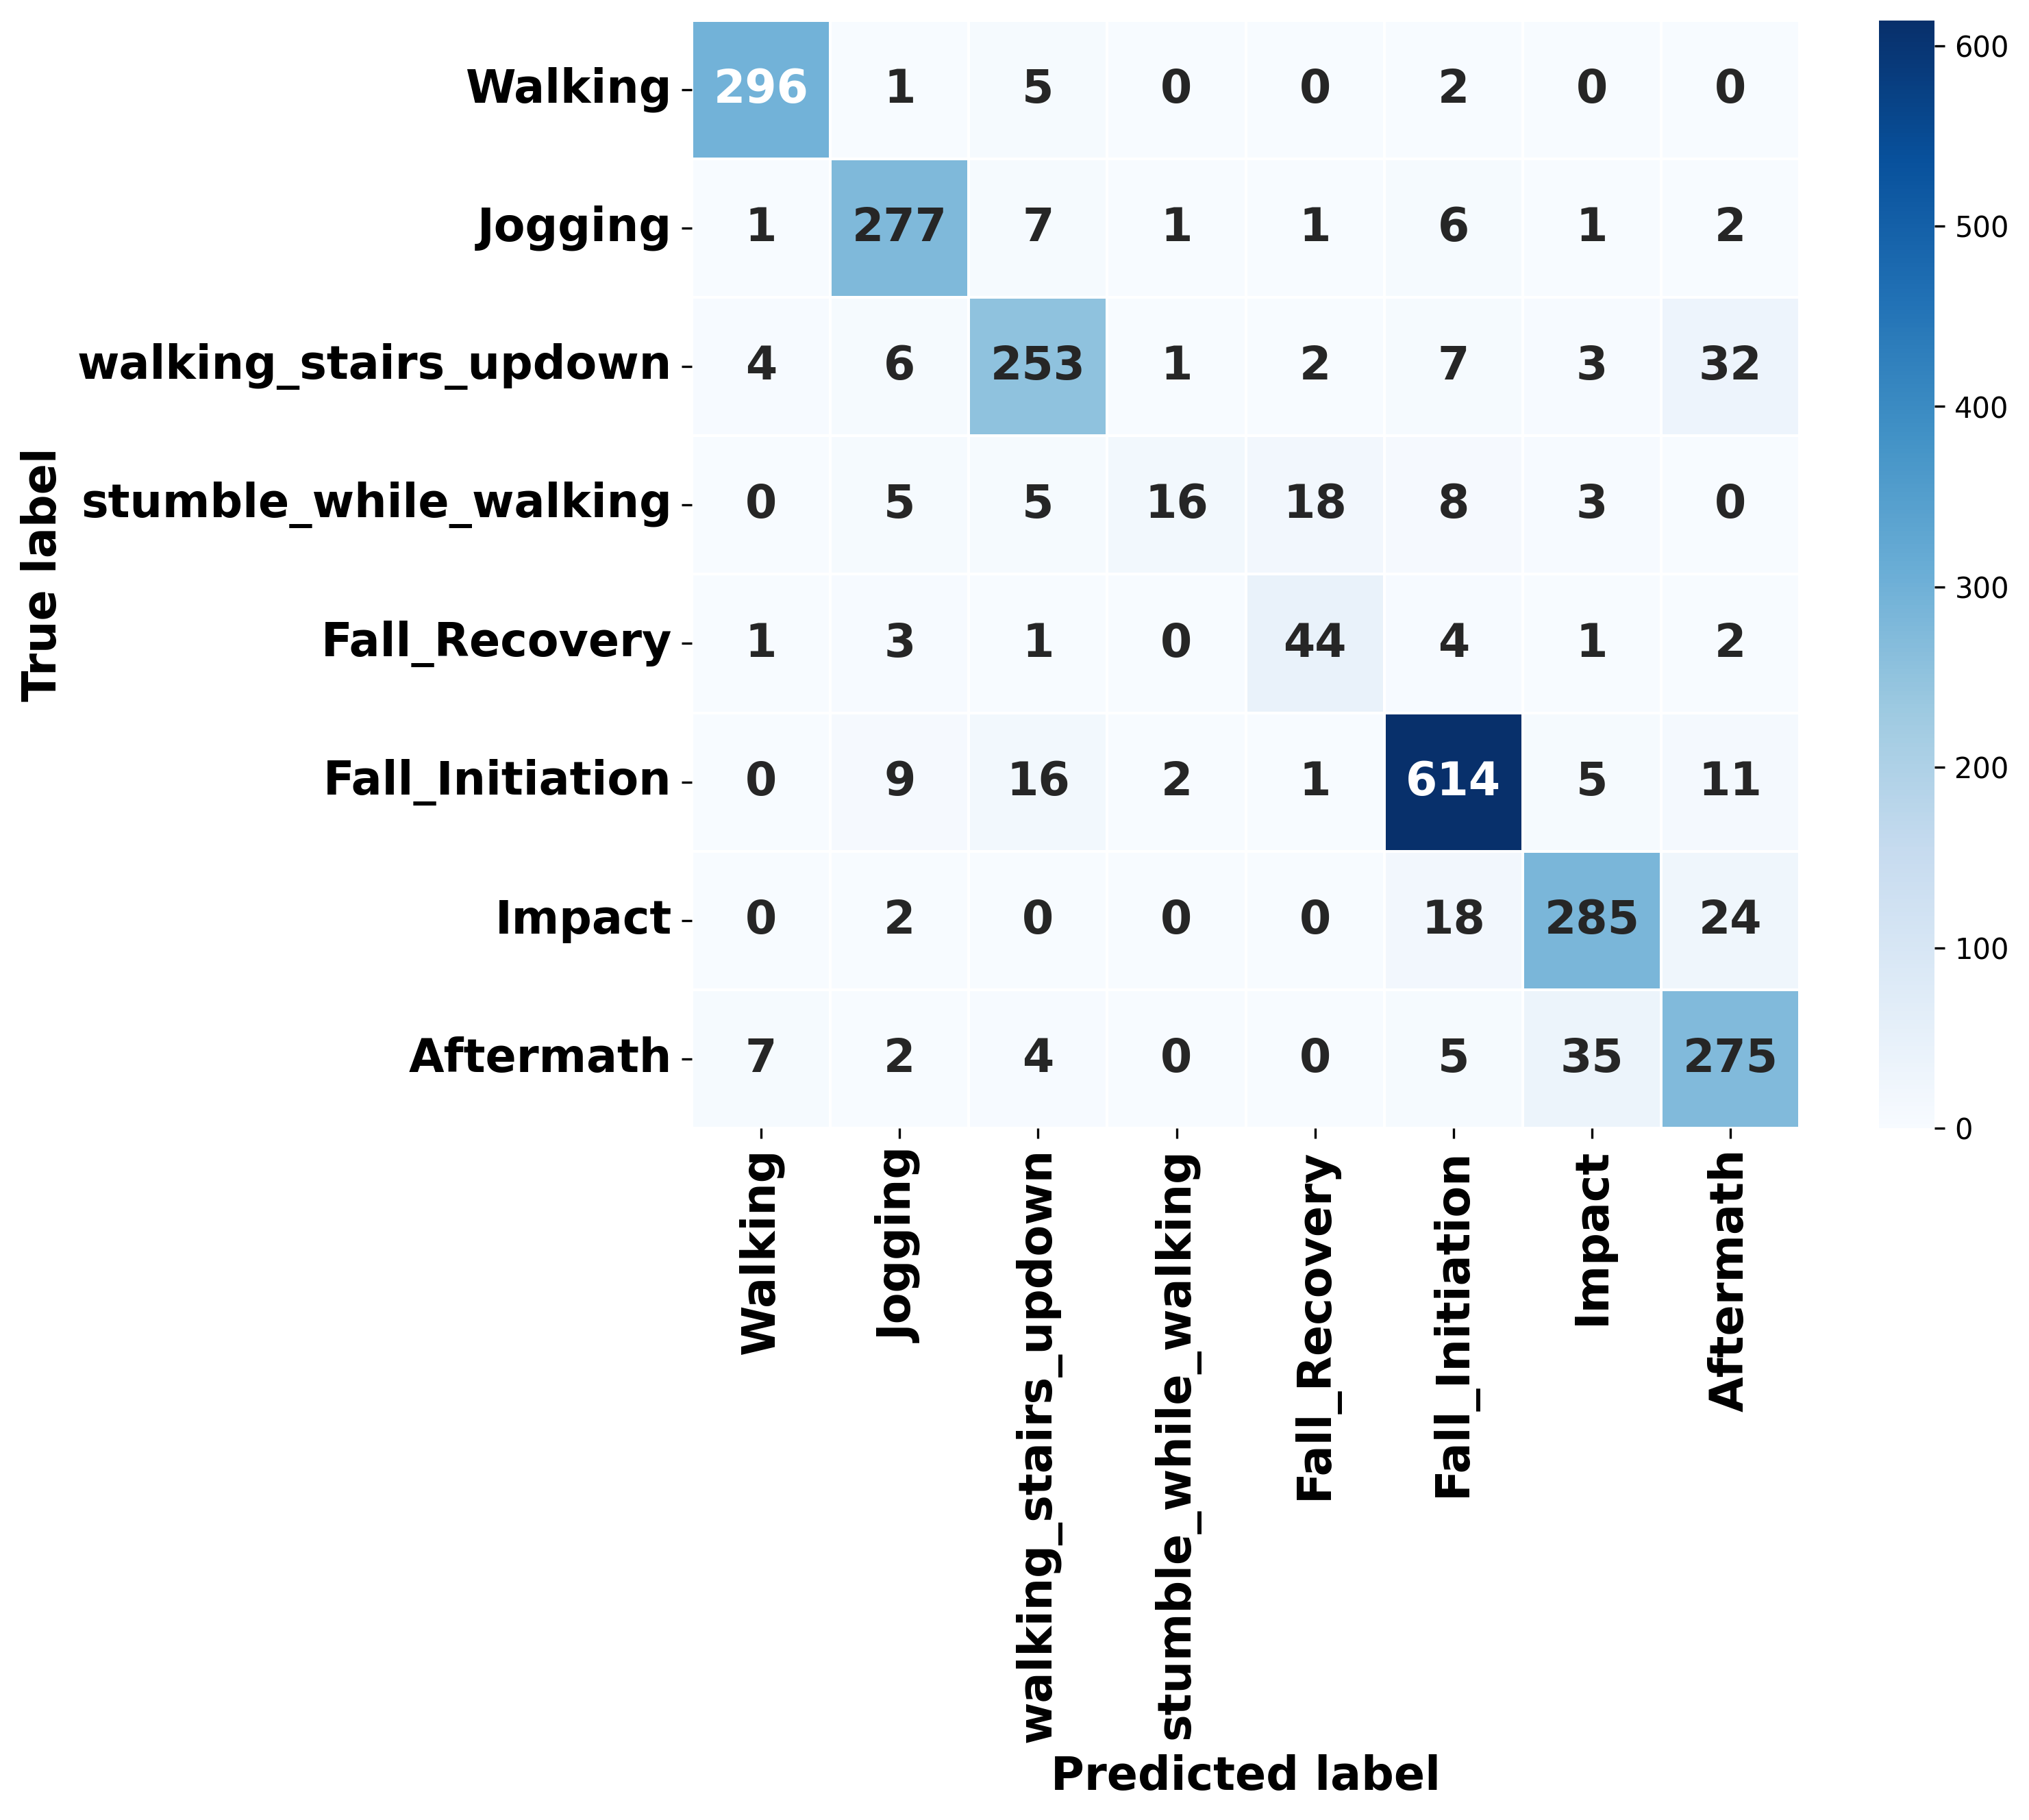

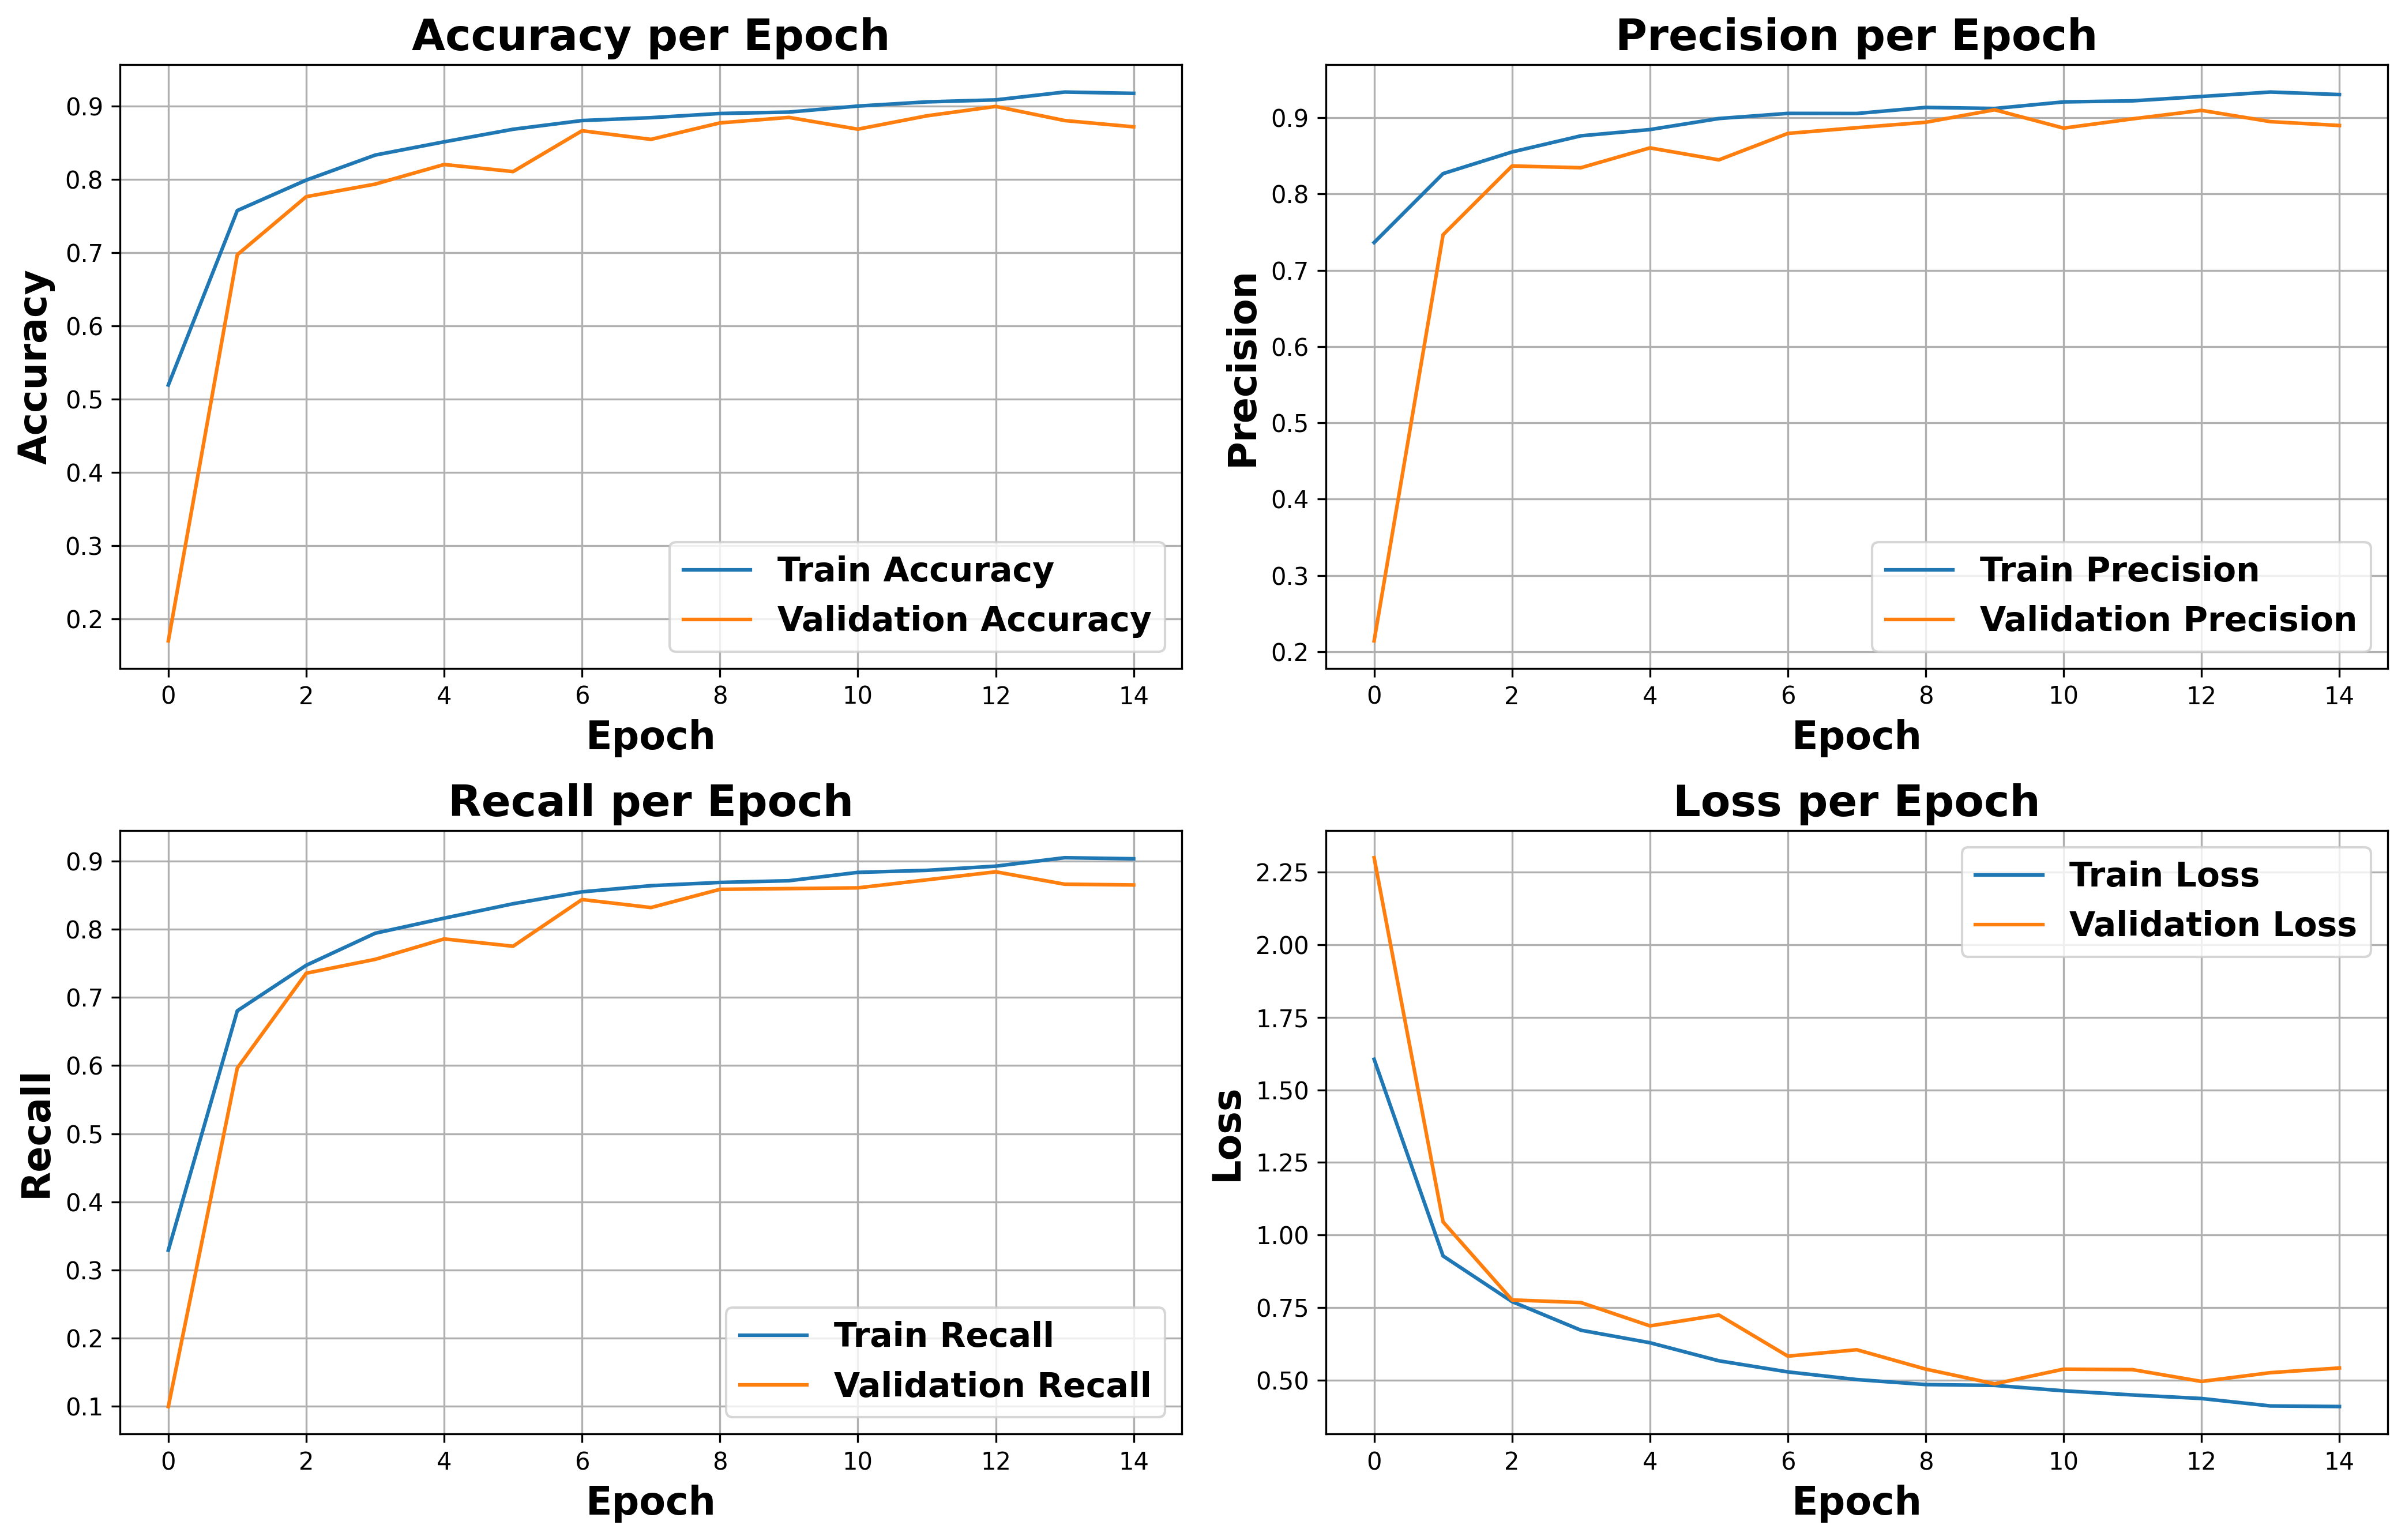

In [30]:
for train_index, test_index in kf.split(final_data, label_copy):
    print(f"Fold {fold_no} :")

    X_train, X_test = final_data[train_index], final_data[test_index]
    y_train, y_test = label[train_index], label[test_index]

    model = ENSEMBLE(I_Shape, n_classes)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['Accuracy','Precision','Recall'])

    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    history = model.fit(
        X_train,
        y_train,
        batch_size=32,
        epochs=200,
        shuffle=True,
        validation_split=0.1,
        verbose=1,
        callbacks=[early_stopping]
    )

    loss, accuracy, precision, recall = model.evaluate(X_test, y_test, batch_size=32, verbose=0)
    accuracies.append(accuracy)
    losses.append(loss)
    precisions.append(precision)
    recalls.append(recall)

    predictions = model.predict(X_test)
    y_true = np.argmax(y_test, axis=1)
    y_pred = np.argmax(predictions, axis=1)

    report = classification_report(y_true, y_pred, target_names=class_labels, output_dict=True)
    print(pd.DataFrame(report).T)

    cm = confusion_matrix(y_true, y_pred)

    axis_labels = [i for i in class_labels]
    figure, ax = plt.subplots(figsize=(10, 7), dpi=300)
    res=sns.heatmap(cm,
            annot=True,
            xticklabels=axis_labels,
            yticklabels=axis_labels,
            linewidths = 0.5,
            square = True,
            fmt='d',
            cmap='Blues',
            ax=ax,
            annot_kws={'fontsize': 16,
                       'fontweight': 'bold'})
    res.set_xticklabels(labels=axis_labels, size=16, weight='bold')
    res.set_yticklabels(labels=axis_labels, size=16, weight='bold')
    plt.ylabel('True label', size=16, weight='bold')
    plt.xlabel('Predicted label', size=16, weight='bold')
    plt.show()

    plt.figure(figsize=(14, 9), dpi=300)

    plt.subplot(2, 2, 1)
    plt.plot(history.history['Accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_Accuracy'], label='Validation Accuracy')
    plt.title(f'Accuracy per Epoch', size=18, weight='bold')
    plt.xlabel('Epoch', size=16, weight='bold')
    plt.ylabel('Accuracy', size=16, weight='bold')
    plt.legend(prop={'weight': 'bold', 'size': 14})
    plt.grid(True)

    plt.subplot(2, 2, 2)
    plt.plot(history.history['precision'], label='Train Precision')
    plt.plot(history.history['val_precision'], label='Validation Precision')
    plt.title(f'Precision per Epoch', size=18, weight='bold')
    plt.xlabel('Epoch', size=16, weight='bold')
    plt.ylabel('Precision', size=16, weight='bold')
    plt.legend(prop={'weight': 'bold', 'size': 14})
    plt.grid(True)

    plt.subplot(2, 2, 3)
    plt.plot(history.history['recall'], label='Train Recall')
    plt.plot(history.history['val_recall'], label='Validation Recall')
    plt.title(f'Recall per Epoch', size=18, weight='bold')
    plt.xlabel('Epoch', size=16, weight='bold')
    plt.ylabel('Recall', size=16, weight='bold')
    plt.legend(prop={'weight': 'bold', 'size': 14})
    plt.grid(True)

    plt.subplot(2, 2, 4)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Loss per Epoch', size=18, weight='bold')
    plt.xlabel('Epoch', size=16, weight='bold')
    plt.ylabel('Loss', size=16, weight='bold')
    plt.legend(prop={'weight': 'bold', 'size': 14})
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    fold_no += 1

In [31]:
print("5-Fold Cross Validation Result")
print(f"Average Accuracy : {np.mean(accuracies):.4f}")
print(f"Average Precision : {np.mean(precisions):.4f}")
print(f"Average Recall : {np.mean(recalls):.4f}")
print(f"Average Loss : {np.mean(losses):.4f}")

5-Fold Cross Validation Result
Average Accuracy : 0.8924
Average Precision : 0.9090
Average Recall : 0.8820
Average Loss : 0.4917


In [32]:
model.save('model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [33]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

with open('model.tflite', 'wb') as f:
    f.write(tflite_model)

In [34]:
interpreter = tf.lite.Interpreter(model_path='model.tflite')
interpreter.allocate_tensors()

In [35]:
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [36]:
input_data = np.array(X_test, dtype=np.float32)
tflite_predictions = []

for i in range(input_data.shape[0]):
    interpreter.set_tensor(input_details[0]['index'], input_data[i:i+1])
    interpreter.invoke()
    output = interpreter.get_tensor(output_details[0]['index'])
    tflite_predictions.append(output)

In [37]:
tflite_predictions = np.array(tflite_predictions).squeeze()
tflite_accuracy = np.mean(np.argmax(tflite_predictions, axis=1) == np.argmax(y_test, axis=1))

print(f'Model (.tflite) Accuracy : {tflite_accuracy:.4f}')

Model (.tflite) Accuracy : 0.8822


In [ ]:
!xxd -i model.tflite > model.h